#### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
import shap
import re

from prince import MCA

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

2024-04-11 21:20:53.250118: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 21:20:53.300266: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 21:20:53.301109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 21:21:00.751365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/sandeepc98/.conda/envs/ssa/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True i

In [2]:
target_encoding = {0: 0, 1: 1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10}
params = {
    'objective': 'multiclass',
    'num_classes': len(target_encoding),
    'metric': 'multi_logloss',
    'verbose': -1
}

#### Preprocessing Utils

In [3]:
def backward(X_train, X_test, y_train, model, feature_reduction_count):
    sfs = SequentialFeatureSelector(model, direction='backward', scoring='r2', n_features_to_select=feature_reduction_count)
    sfs.fit(X_train, y_train)
    return (sfs.transform(X_train), sfs.transform(X_test))

def Stepwise_selection(X_train, X_test, y_train, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05
                       ):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X_train.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
        # backward step
        model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
        if not changed:
            break

    new_X_train = X_train[included]
    new_X_test = X_test[included]
    return (new_X_train, new_X_test)

def Univariate(X_train, X_test, y_train, k):
    k_best = SelectKBest(f_classif, k = k)
    X_train = k_best.fit_transform(X_train, y_train)
    X_test = k_best.transform(X_test)
    selected = k_best.get_support(indices=True)
    return (X_train, X_test, selected)

def Pca(X_train, X_test, y_train, n_components=100):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    pca = PCA(n_components = n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    explained_variance = pca.explained_variance_ratio_
    
    # perform PCA Unloading as a part of the PCA function
    print(X_train)
    print(X_train[:,0])
    
    n_pcs= pca.components_.shape[0]
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    initial_feature_names = feature_names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
    pca_to_feature = pd.DataFrame(dic.items())
    pca_feature_names = pca_to_feature[1].tolist()

    return (X_train, X_test, pca_feature_names, explained_variance)

def Mca(X, feature_names, n_components=100):
    
    # Perform MCA on X
    mca = MCA(n_components=n_components)
    mca.fit(X)
    X_mca = mca.transform(X)

    # Find the row (index) with the highest contribution for each component
    column_contributions = mca.column_contributions_
    most_contributing_features = column_contributions.idxmax()
    
    # Construct a map from MCA components to original features - not necessary right now, but just to visualize
    mca_to_original_mapping = {i+1: most_contributing_features[i] for i in range(len(most_contributing_features))}

    mca_feature_names = []
    for i in range(len(most_contributing_features)):
        mca_feature_names.append(most_contributing_features[i])
    
    return X_mca, mca_feature_names

def split(X, y, test_size = 0.2, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    return (X_train, X_test, y_train, y_test)

In [4]:
# Wrapper for CNN Util
class KerasClassifierWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, verbose=0)
        return self

    def score(self, X, y):
        _, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy

# CNN Util function
def cnn_util(X_train, y_train, X_test, y_test, selection, num_classes=len(target_encoding), epochs=150, batch_size=64, cv=3):
    # Reshape the input data to a 3D tensor for the CNN
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    wrapped_model = KerasClassifierWrapper(model)
    scores = cross_val_score(wrapped_model, X_train, y_train, cv=cv)
    train_accuracy = scores.mean()

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print("***********************************************************************************")
    print("Model                       =  CNN")
    print("Feature Selection Criteria  = ", selection)
    print("Train Accuracy              = ", train_accuracy)
    print("Test Accuracy               = ", test_accuracy)

    return train_accuracy, test_accuracy, model

#### Visualization Methods

In [13]:
def plot(y_pred_proba, y_test, target_encoding):
    
    # Plot the ROC curve for the model
    plot_roc_curve(y_pred_proba, y_test, target_encoding)

    # Plot the PR curve of the model
    plot_pr_curve(y_pred_proba, y_test, target_encoding)

def shap_summary(model, X_test, feature_names, eval):
    # Construct a Summary plot with 10 most important features (the feature names are replaced with gene names)
    if(eval == "DecisionTreeGini" or eval == "DecisionTreeEntropy" or eval == "RandomForest" or eval == "XGBoost" or eval == "lightGBM"):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False, max_display=10)
        plt.savefig("Ralstonia_shap_summary.pdf",dpi=700)

# def shap_summary(model, X_test, feature_names, eval):
#     if eval in ["DecisionTreeGini", "DecisionTreeEntropy", "RandomForest", "XGBoost", "lightGBM"]:
#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer.shap_values(X_test)
#     elif eval == "MLP":
#         # Use KernelExplainer for the MLP model
#         explainer = shap.KernelExplainer(model.predict_proba, X_test)
#         shap_values = explainer.shap_values(X_test, nsamples='auto')  # 'auto' can be replaced with a specific number of samples if needed
#     else:
#         raise ValueError(f"Model type {eval} not supported for SHAP analysis")
#     # Construct a Summary plot with 10 most important features
#     shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", max_display=10)
#     plt.savefig("Ralstonia_SHAP_summary.pdf", dpi=700)

In [6]:
def plot_roc(X_test, y_test, model):
    levels = len(y_pred_prob[0])
    print("levels: " + str(levels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(levels):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:,  i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("---------FPR-----------")
    print(fpr[1])
    print("---------TPR-----------")
    print(tpr[1])
    plt.figure()
    lw = 2
    for i in range(levels):

        plt.plot(fpr[i], tpr[i], lw=lw,
                label='ROC curve (area = %0.2f)' % (roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver operating characteristic for multi-class GBC')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20)):
    """
    Plots the learning curve of a decision tree classifier with misclassification rate as the loss function.
    
    Parameters:
    estimator (sklearn classifier): A decision tree classifier object from scikit-learn.
    title (string): Title of the plot.
    X (array-like, shape (n_samples, n_features)): The input data.
    y (array-like, shape (n_samples)): The target values.
    ylim (tuple): The y-axis limits. If None, the y-axis limits are automatically set.
    cv (int): Number of cross-validation folds. If None, the default value of 5 is used.
    n_jobs (int): Number of parallel jobs. If None, the default value of 1 is used.
    train_sizes (array-like, shape (n_ticks)): Relative or absolute numbers of training examples.
    
    Returns:
    matplotlib plot: A plot of the learning curve.
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy"
    )

    # Calculate the mean and standard deviation of the training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation accuracy")
    plt.legend(loc="best")
    return plt

In [8]:
def plot_roc_curve(y_pred_proba, y_test, class_dict):
    '''
    Plots ROC curves for each class in a multi-class classification problem
    using the "one-vs-rest" approach.

    Parameters:
        -- y_test (array-like): true labels of the test data.
        -- y_pred_proba (array-like): predicted probabilities for each class.
                                    Shape should be (n_samples, n_classes).
        -- class_dict (dict): dictionary containing class names as keys and their corresponding
                              target encodings as values.

    Returns:
        -- None
    '''
    # Compute ROC curve for each class using the "one-vs-rest" approach
    n_classes = y_pred_proba.shape[1]
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        class_name = [key for key, value in class_dict.items() if value == i][0]
        y_true_class = np.array([1 if y == i else 0 for y in y_test])
        fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_proba[:, i])
        print(i, fpr.shape, tpr.shape, thresholds.shape)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='Class %d: %s (AUC = %0.2f)' % (i, class_name, roc_auc))
        
    print(fpr)
    print(tpr)
    
    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Multi-Class, One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.show()

In [9]:
def plot_pr_curve(y_pred_proba, y_test, class_dict):
    '''
    Plots Precision-Recall curves for each class in a multi-class classification problem.

    Parameters:
        -- y_test (array-like): true labels of the test data.
        -- y_pred_proba (array-like): predicted probabilities for each class.
                                    Shape should be (n_samples, n_classes).
        -- class_dict (dict): dictionary containing class names as keys and their corresponding
                              target encodings as values.

    Returns:
        -- None
    '''
    # Compute Precision-Recall curve for each class
    n_classes = y_pred_proba.shape[1]
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        class_name = [key for key, value in class_dict.items() if value == i][0]
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, i], pos_label=i)
        print(i, precision.shape, recall.shape, thresholds.shape)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label='Class %d: %s (AUC = %0.2f)' % (i, class_name, pr_auc))
    
    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Multi-Class)')
    plt.legend(loc='lower left')
    plt.show()

#### Main Function

In [10]:
def run_model(X, y, selection, eval, target_encoding, feature_names, feature_reduction_count=100, cv=3, shap=False, learning_curve=False):

    # Dictionary to map selection methods
    selection_methods = {"none": None, "pca": Pca, "mca": Mca, "univariate": Univariate}

    if selection == "mca":
        X, feature_names = Mca(X, feature_names, feature_reduction_count)
    
    X_train, X_test, y_train, y_test = split(X, y)
    
    # Feature Selection
    if selection != "none" and selection != "pca" and selection != "mca":
        X_train, X_test, *args = selection_methods[selection](X_train, X_test, y_train, feature_reduction_count)
        
    # PCA case requires a change in feature names (PCA unloading) for the SHAP explanation plot
    if selection == "pca":
        X_train, X_test, pca_feature_names, *args = selection_methods[selection](X_train, X_test, y_train, feature_reduction_count) 

    # Train the model
    train_accuracy, test_accuracy, model, X_test = train(X, y, X_train, X_test, y_train, y_test, num_features=feature_reduction_count, selection=selection, eval=eval, cv=cv, target_encoding=target_encoding, learning_curve=learning_curve)

    if shap == True:
        if selection == "pca":
            shap_summary(model, X_test, pca_feature_names, eval)
        else:
            shap_summary(model, X_test, feature_names, eval)
        #plot(y_pred_proba, y_test, target_encoding)

    return train_accuracy, test_accuracy, model

In [11]:
def train(X, y, X_train, X_test, y_train, y_test, num_features, selection, eval, cv, target_encoding, learning_curve=False):
    
    # Dictionary to map evaluation models
    evaluation_models = {
        "DecisionTreeGini": DecisionTreeClassifier(criterion="gini", max_depth=4),
        "DecisionTreeEntropy": DecisionTreeClassifier(criterion="entropy", max_depth=4),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='rbf', C=1, gamma='scale', probability=True),
        "XGBoost": xgb.XGBClassifier(objective='binary:logistic', n_estimators=100),
        "lightGBM": lgb.LGBMClassifier(objective='binary', num_boost_round=1000, early_stopping_rounds=10, verbose_eval=False),
        "MLP": MLPClassifier(hidden_layer_sizes=(150, 100, 150), activation='relu', random_state=42, max_iter=500)
    }
        
    train_accuracy = 0
    
    # Select the model
    if eval == "cnn":
        train_accuracy, test_accuracy, model = cnn_util(X_train, y_train, X_test, y_test, selection, cv=cv)
        return train_accuracy, test_accuracy, model, X_test
    elif eval != "lightGBM":
        model = evaluation_models[eval]
        train_accuracy = np.mean(cross_val_score(model, X_train, y_train, cv=cv))
    else:
        # Convert the data into Light GBM's Dataset format
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)
        
        evals_result = {}  # Dictionary to store the evaluation results
        
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=1000,
            early_stopping_rounds=10,
            verbose_eval=10,
            evals_result=evals_result  # Store the evaluation results
        )
        
        # Make predictions on the training data
        train_predictions = model.predict(X_train)
        train_predictions = np.round(train_predictions)
        train_predictions_labels = train_predictions.argmax(axis=1)
        train_accuracy = accuracy_score(y_train, train_predictions_labels)
        
        # Calculate Test Accuracy of LGBM
        y_pred = model.predict(X_test)
        test_accuracy = (y_pred.argmax(axis=1) == y_test).mean()
        
        if learning_curve:
            # Plot the learning curve
            train_loss = evals_result['training']['multi_logloss']
            valid_loss = evals_result['valid_1']['multi_logloss']
            num_rounds = len(train_loss)
            x_axis = range(1, num_rounds + 1)
            plt.plot(x_axis, train_loss, label='Train')
            plt.plot(x_axis, valid_loss, label='Test')
            plt.xlabel('Number of Boosting Rounds')
            plt.ylabel('Multi-logloss')
            plt.legend()
            plt.savefig('Ralstonia_LearningCurve.jpg', dpi=600)
            plt.show()
    
    # Calculate Test and Train Accuracies of the models
    y_pred_proba = [] 
    if eval != "lightGBM":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_test_prediction = model.predict_proba(X_test)
        test_predicted_classes = np.argmax(y_test_prediction, axis=1)
        test_accuracy = np.mean(test_predicted_classes == y_test)
        # if learning_curve == True:
        #     plt = plot_learning_curve(model, "Learning Curve (" + eval + ", " + selection + "):" , X_train, y_train)
        #     plt.savefig('Ralstonia_LearningCurve.jpg', dpi=600)
    # Print the Statistics
    print("***********************************************************************************")
    print("Model                       = ", eval)
    print("Feature Selection Criteria  = ", selection)
    print("Train Accuracy              = ", train_accuracy)
    print("Test Accuracy               = ", test_accuracy)    
    
    return train_accuracy, test_accuracy, model, X_test

In [12]:
selections = ['none','univariate','pca'] # Default Feature Selection Metrics
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','lightGBM','MLP', 'CNN'] # Default ML Models

def pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True, feature_reduction_count=100, cv=3, threshold=10000):
    
    # Import Dataset as DataFrame
    df = pd.read_csv(dataset_path, index_col=0)

    # df['dummy_gene'] = df['target'].apply(lambda x: 1 if x == 'Bovine' else 0)
    # feature_names = df.columns

    # print("Dummy Gene Distribution", df['dummy_gene'].value_counts())

    # Remove genes to remove
    # df = df.drop(columns=gene_to_remove)
    
    # Encode Targets with Integers
    df = df.replace(target_encoding)
    
    # If any Nucleotides are Present, encode them
    if(nucleotides_data):
        encoding = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
        df = df.replace(encoding)

    # Drop columns with only one unique value
    df = df.loc[:, df.nunique() > 1]

    # Split the Dataset
    X = df.drop('target', axis=1)
    y = df['target']

    print(" The shape of X is ", X.shape[1])
    
    # Apply Threshold for using all features in the ML
    if X.shape[1] > threshold and 'none' in selections:
        selections.remove('none')

    results = []  # To store results in a list of dictionaries for creating a table
    max_accuracy = 0
    best_performance_model = ''
    best_performance_fs = ''

    for selection in selections:
        for model in models:
            # Compute Accuracy of the model
            curr_accuracy, test_accuracy, _ = run_model(X, y, selection=selection, eval=model, target_encoding=target_encoding, feature_names=feature_names, feature_reduction_count=feature_reduction_count, cv=3)

            # Store results in a dictionary
            result = {'Model': model, 'Selection': selection, 'Train_Accuracy': curr_accuracy, 'Test_Accuracy': test_accuracy}
            results.append(result)

            if test_accuracy > max_accuracy:
                max_accuracy = test_accuracy
                best_performance_model = model
                best_performance_fs = selection

    # Create a dataframe from the results list
    results_df = pd.DataFrame(results)

    print("***********************************************************************************")
    print("Completed Training All models")
    print("The Best Accuracy: ", max_accuracy)
    print("The Best Performing Combination is: Model: ", best_performance_model, " and Feature Selection: ",
          best_performance_fs)
    
    # Call SHAP for the best performing model
    _, _, best_model = run_model(X, y, selection=best_performance_fs, eval=best_performance_model, target_encoding=target_encoding, feature_names=feature_names, feature_reduction_count=100, cv=3, shap=True, learning_curve=True)
    # shap_summary(best_model) 

    return results_df

### Training results

 The shape of X is  2437
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.3768187830687831
Test Accuracy               =  0.2916666666666667
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.36127645502645506
Test Accuracy               =  0.3125
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.4395667989417989
Test Accuracy               =  0.4583333333333333
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  none
Train Accuracy              

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  none
Train Accuracy              =  0.37161044973544977
Test Accuracy               =  0.4375


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.33969907462596893
Test Accuracy               =  0.4166666567325592
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 1.5157	valid_1's multi_logloss: 1.81372
[20]	training's multi_logloss: 1.2794	valid_1's multi_logloss: 1.82187
Early stopping, best iteration is:
[15]	training's multi_logloss: 1.37797	valid_1's multi_logloss: 1.79341
***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  none
Train Accuracy              =  0.3769633507853403
Test Accuracy               =  0.3958333333333333
[[-1.28895885 -0.88698948 -0.6365237  ...  0.09261799 -0.31823481
   0.09508825]
 [-1.35735154 -1.07810413 -0.80309584 ...  0.05487346  0.126044
   0.01976549]
 [-1.25891185 

[[-1.28895885e+00 -8.86989482e-01 -6.36523696e-01 ...  3.56952928e-02
  -2.69324300e-01  9.87849569e-02]
 [-1.35735154e+00 -1.07810413e+00 -8.03095839e-01 ...  8.69949233e-02
   9.33253260e-02  1.06298756e-02]
 [-1.25891185e+00 -9.55162124e-01 -6.18274159e-01 ... -1.55023707e-01
   7.17775924e-04  1.15559623e-01]
 ...
 [-1.27097699e+00 -8.91819922e-01 -6.40349648e-01 ...  5.04359377e-02
  -2.37010903e-01  5.54708515e-02]
 [-1.26820108e+00 -8.48818087e-01 -6.05073353e-01 ...  9.67593329e-02
  -2.94235498e-01  2.27717897e-02]
 [-1.29871834e+00 -8.99188826e-01 -6.47490500e-01 ... -1.27365895e-01
  -2.80446580e-02 -1.06380703e-01]]
[ -1.28895885  -1.35735154  -1.25891185  -1.23919548  -1.28865189
  -1.08783934  -1.27097699  -1.28858765  -1.11325577  -1.2889705
  -1.2396309   -1.33191649  -1.23586194  -1.28871714  -0.99766609
  -1.29358247  -1.2888455   -1.10245986  -1.28846867  -1.28849413
  -1.28092566  -1.40856092  -0.91803365  -1.14968237  -1.11234196
  -1.28857264  -1.10956441  -1.3046

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.3400297661622365
Test Accuracy               =  0.4583333432674408
[[-1.28895885e+00 -8.86989482e-01 -6.36523696e-01 ... -7.59878328e-02
  -2.57839274e-01  8.54892894e-02]
 [-1.35735154e+00 -1.07810413e+00 -8.03095839e-01 ... -3.19178438e-02
   1.57380115e-01 -2.81919067e-02]
 [-1.25891185e+00 -9.55162124e-01 -6.18274159e-01 ...  1.00460954e-01
  -3.72173907e-02  2.38556303e-01]
 ...
 [-1.27097699e+00 -8.91819922e-01 -6.40349649e-01 ... -1.18344807e-01
  -4.34171193e-01  1.01514663e-01]
 [-1.26820108e+00 -8.48818087e-01 -6.05073353e-01 ... -1.29351265e-01
  -2.81839073e-01 -1.15271225e-03]
 [-1.29871834e+00 -8.99188826e-01 -6.47490500e-01 ...  2.27209494e-01
  -2.03344097e-02 -1.24999514e-01]]
[ -1.28895885  -1.35735154  -1.25891185  -1.23919548  -1.28865189
  -1.08783934  -1.27097699  -1.28858765  -1.

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.376819       0.291667
1   DecisionTreeEntropy      none        0.361276       0.312500
2          RandomForest      none        0.439567       0.458333
3                   SVM      none        0.397817       0.375000
4               XGBoost      none        0.418816       0.375000
5                   MLP      none        0.371610       0.437500
6                   cnn      none        0.339699       0.416667
7              lightGBM      none        0.376963       0.395833
8      DecisionTreeGini       pca        0.340443       0.437500
9   DecisionTreeEntropy       pca        0.366402       0.354167
10         RandomForest       pca        0.429398       0.562500
11                  SVM       pca        0.350777       0.437500
12              XGBoost       pca        0.397817       0.458333
13                  MLP       pca        0.334987       0.520833
14                  cnn       pca        0.340030       0.458333
15             lightGBM       pca        0.984293       0.500000

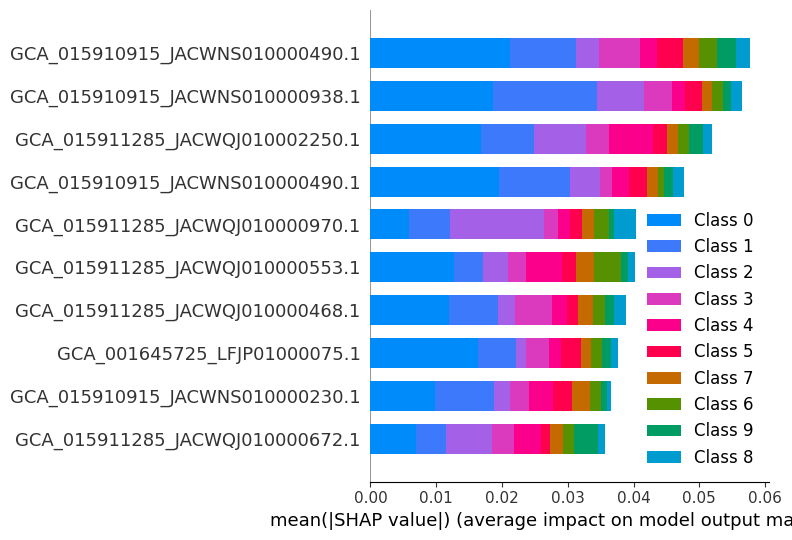

In [15]:
# Run 11/03/23
# Top 10 Sources
import warnings
warnings.filterwarnings('ignore')

# Set the hyperparameters for the Light GBM model

target_encoding = {0: 0, 1: 1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}


params = {
    'objective': 'multiclass',
    'num_classes': len(target_encoding),
    'metric': 'multi_logloss',
    'verbose': -1
}

# path for the dataset
dataset_path = "dataset/dataset_pa_top10.csv"
feature_names_path = "dataset/dataset_pa_top10.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()
# Drop 'Unnamed: 0' from the feature_names
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none', 'pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','XGBoost','MLP','cnn','lightGBM'] # Default ML Models 

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5:5, 6:6, 7:7, 8:8, 9:9}

results = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results

In [16]:
results

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.376819       0.291667
1   DecisionTreeEntropy      none        0.361276       0.312500
2          RandomForest      none        0.439567       0.458333
3                   SVM      none        0.397817       0.375000
4               XGBoost      none        0.418816       0.375000
5                   MLP      none        0.371610       0.437500
6                   cnn      none        0.339699       0.416667
7              lightGBM      none        0.376963       0.395833
8      DecisionTreeGini       pca        0.340443       0.437500
9   DecisionTreeEntropy       pca        0.366402       0.354167
10         RandomForest       pca        0.429398       0.562500
11                  SVM       pca        0.350777       0.437500
12              XGBoost       pca        0.397817       0.458333
13                  MLP       pca        0.334987       0.520833
14                  cnn       pca        0.340030       0.458333
15             lightGBM       pca        0.984293       0.500000

In [26]:
results = results.round(2)
results.rename(columns={"Train Accuracy": "Train_Accuracy", "Test Accuracy": "Test_Accuracy"}, inplace=True)
sorted_results = results.sort_values(by='Test_Accuracy', ascending=False)
file_path = 'results/10_Machine_Learning/SourceTracking_Ralstonia_Table7_Dataset_Top10.csv'
sorted_results.to_csv(file_path, index=False)

 The shape of X is  5437
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.3473963775687914
Test Accuracy               =  0.07575757575757576
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.35488505747126436
Test Accuracy               =  0.030303030303030304
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.40460640891675376
Test Accuracy               =  0.06060606060606061
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  none
Train Accur

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.33594565590222675
Test Accuracy               =  0.39393940567970276
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 1.43817	valid_1's multi_logloss: 1.85509
Early stopping, best iteration is:
[6]	training's multi_logloss: 1.56803	valid_1's multi_logloss: 1.84575
***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  none
Train Accuracy              =  0.061068702290076333
Test Accuracy               =  0.2878787878787879
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.3473963775687914
Test Accuracy     

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.4084813653779171
Test Accuracy               =  0.10606060606060606


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.2862243056297302
Test Accuracy               =  0.3333333432674408
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 1.52255	valid_1's multi_logloss: 1.87374
Early stopping, best iteration is:
[5]	training's multi_logloss: 1.63902	valid_1's multi_logloss: 1.84824
***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.07633587786259542
Test Accuracy               =  0.24242424242424243
[[-3.14066948 -1.10202221 -0.67650026 ... -0.85761211  1.54774411
  -0.89727989]
 [-3.31609953 -1.06386422 -0.68571736 ... -0.53633625 -0.62512004
   0.75106521]
 [-3.3106314  -1.04547654 -0.68578746 ...  0.02493679  0.02627273
   0

[[-3.14066948 -1.10202221 -0.67650025 ... -0.52587587  0.74169725
  -0.87556886]
 [-3.31609953 -1.06386422 -0.68571729 ... -1.65227645  0.57752767
  -1.53498883]
 [-3.3106314  -1.04547654 -0.68578746 ... -0.0158451  -0.02138351
   0.1792835 ]
 ...
 [-3.31562364 -0.70993721 -0.69462892 ...  0.16283111  0.01391664
   0.20403784]
 [-3.19286368 -0.96898434 -0.2189159  ... -0.56282847  0.97124417
   0.25576237]
 [-3.31608528 -1.06382636 -0.686322   ... -0.36929904 -0.46294173
  -0.09515098]]
[-3.14066948e+00 -3.31609953e+00 -3.31063140e+00 -3.23239373e+00
 -3.23938357e+00 -3.31635447e+00 -3.31606047e+00 -3.31149408e+00
 -3.30742141e+00 -3.21811026e+00 -3.20516576e+00 -3.30238758e+00
 -3.25952318e+00 -3.22523740e+00 -3.27582806e+00 -3.31550949e+00
 -3.22223763e+00 -3.30928297e+00 -3.31619230e+00 -3.26528492e+00
 -3.30951357e+00 -3.23714698e+00 -3.31608529e+00 -3.22652926e+00
 -3.17252243e+00 -3.23753754e+00 -3.16836723e+00 -3.30865430e+00
 -3.23495912e+00 -3.30421783e+00 -3.30290504e+00 -2.9

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.3244949479897817
Test Accuracy               =  0.4545454680919647
[[-3.14066948e+00 -1.10202221e+00 -6.76500234e-01 ... -1.14831709e-01
   4.55861837e-01  2.91294542e-01]
 [-3.31609953e+00 -1.06386422e+00 -6.85717323e-01 ... -4.59877276e-01
   8.89900546e-01  1.04129443e+00]
 [-3.31063140e+00 -1.04547654e+00 -6.85787457e-01 ... -8.64416084e-02
  -2.07493240e-02  8.47811015e-02]
 ...
 [-3.31562364e+00 -7.09937207e-01 -6.94628919e-01 ...  3.82318661e-02
  -1.92047897e-03  1.19470549e-01]
 [-3.19286368e+00 -9.68984335e-01 -2.18915905e-01 ...  5.88691004e-01
  -3.76173545e-01 -1.22160702e+00]
 [-3.31608528e+00 -1.06382636e+00 -6.86321967e-01 ... -1.25738351e+00
  -1.19648283e-01 -6.81058511e-01]]
[-3.14066948e+00 -3.31609953e+00 -3.31063140e+00 -3.23239373e+00
 -3.23938357e+00 -3.31635447e+00 -3.31606047e

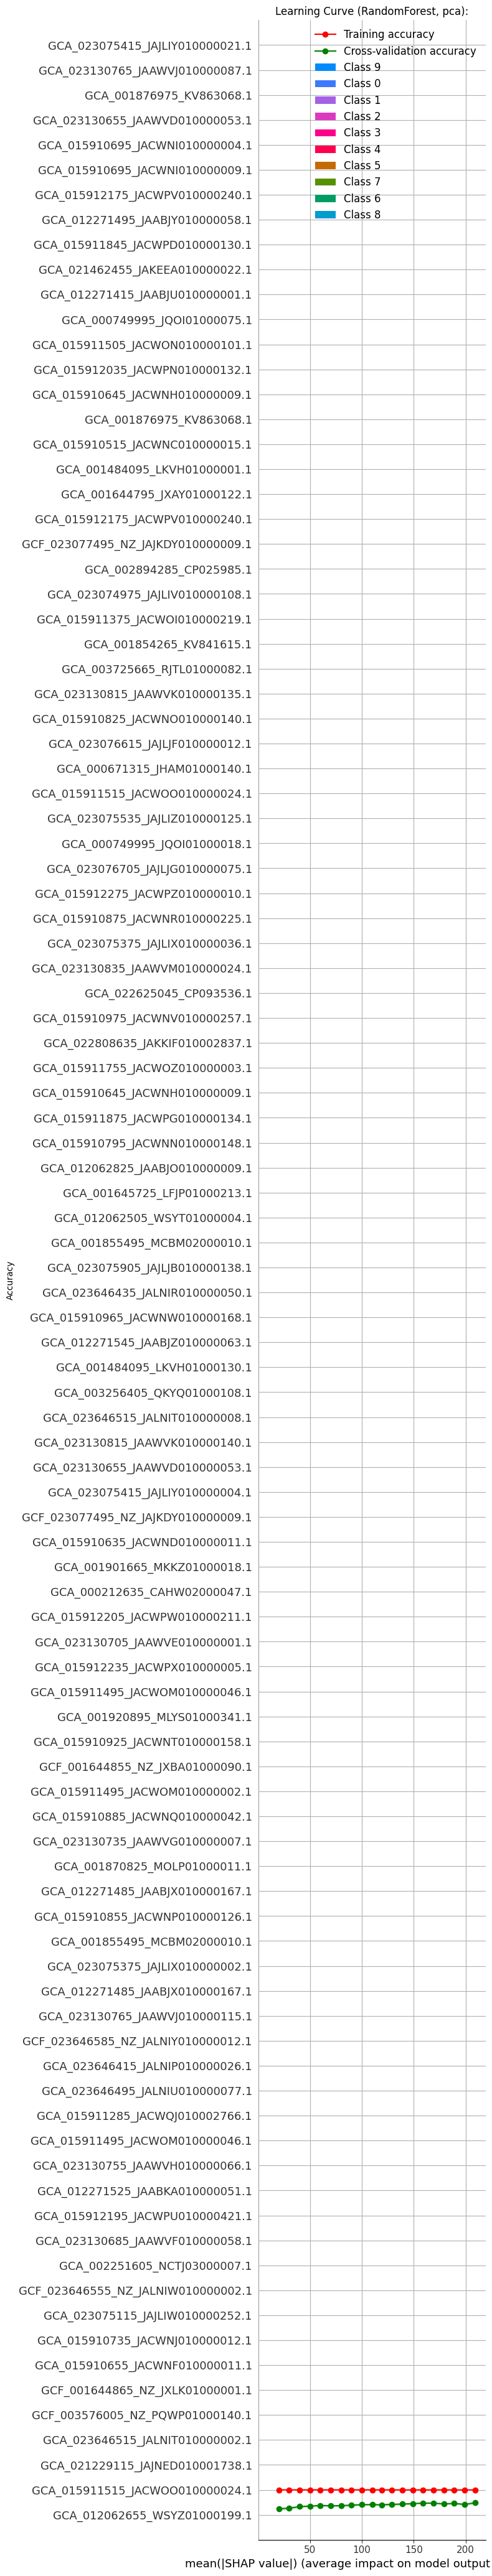

Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini        none        0.347396       0.075758
1   DecisionTreeEntropy        none        0.354885       0.030303
2          RandomForest        none        0.404606       0.060606
3                   SVM        none        0.366510       0.045455
4                   MLP        none        0.385711       0.151515
5                   cnn        none        0.335946       0.393939
6              lightGBM        none        0.061069       0.287879
7      DecisionTreeGini  univariate        0.347396       0.075758
8   DecisionTreeEntropy  univariate        0.355016       0.015152
9          RandomForest  univariate        0.389411       0.075758
10                  SVM  univariate        0.393199       0.045455
11                  MLP  univariate        0.408481       0.106061
12                  cnn  univariate        0.286224       0.333333
13             lightGBM  univariate        0.076336       0.242424
14     DecisionTreeGini         pca        0.282306       0.015152
15  DecisionTreeEntropy         pca        0.316832       0.000000
16         RandomForest         pca        0.427551       0.030303
17                  SVM         pca        0.332201       0.030303
18                  MLP         pca        0.370124       0.060606
19                  cnn         pca        0.324495       0.454545
20             lightGBM         pca        0.213740       0.424242

In [16]:
# Run 11/03/23
# Top 10 Sources
import warnings
warnings.filterwarnings('ignore')

# Set the hyperparameters for the Light GBM model
target_encoding = {0: 0, 1: 1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10}
params = {
    'objective': 'multiclass',
    'num_classes': 11,
    'metric': 'multi_logloss',
    'verbose': -1
}

# path for the dataset
dataset_path = "dataset/dataset_ralstonia_pa_top10.csv"
feature_names_path = "dataset/dataset_pa_top10.csv"

feature_names = pd.read_csv(feature_names_path).columns.tolist()
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none','univariate','pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','MLP','cnn', 'lightGBM'] 
results = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results

In [32]:
results

Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini        none        0.371693       0.312500
1   DecisionTreeEntropy        none        0.361359       0.312500
2          RandomForest        none        0.439567       0.458333
3                   SVM        none        0.397817       0.395833
4               XGBoost        none        0.418816       0.375000
5                   MLP        none        0.371610       0.437500
6                   cnn        none        0.334491       0.437500
7              lightGBM        none        0.376963       0.395833
8      DecisionTreeGini  univariate        0.397983       0.333333
9   DecisionTreeEntropy  univariate        0.413525       0.375000
10         RandomForest  univariate        0.450231       0.354167
11                  SVM  univariate        0.424024       0.333333
12              XGBoost  univariate        0.439897       0.312500
13                  MLP  univariate        0.471561       0.312500
14                  cnn  univariate        0.230159       0.354167
15             lightGBM  univariate        0.335079       0.354167
16     DecisionTreeGini         pca        0.335565       0.416667
17  DecisionTreeEntropy         pca        0.340360       0.416667
18         RandomForest         pca        0.460813       0.541667
19                  SVM         pca        0.350777       0.458333
20              XGBoost         pca        0.403108       0.458333
21                  MLP         pca        0.329778       0.500000
22                  cnn         pca        0.271908       0.437500
23             lightGBM         pca        0.942408       0.520833

 The shape of X is  2268
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.4294871794871795
Test Accuracy               =  0.375
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.4294871794871795
Test Accuracy               =  0.425
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.48717948717948717
Test Accuracy               =  0.55
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  none
Train Accuracy              =  0.5192307692307693
Test A

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  none
Train Accuracy              =  0.4615384615384615
Test Accuracy               =  0.525


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.435897429784139
Test Accuracy               =  0.4749999940395355
[[-1.47453268 -1.17497099 -0.79353813 ...  0.01081764 -0.00280959
  -0.01455796]
 [-1.4482712  -1.14839594 -0.81354216 ...  0.01770653 -0.02375486
   0.00789696]
 [-1.32842313 -0.48197681 -0.42352383 ... -0.04520913 -0.1457688
  -0.05741307]
 ...
 [-1.39863098 -1.09060337 -0.80178693 ... -0.10766601 -0.03779131
  -0.02779572]
 [-1.26126451 -0.85348137 -0.59931315 ... -0.33661569 -0.28842033
  -0.24519244]
 [-0.76231608 -1.04404998 -0.64718021 ...  0.01041653  0.02484055
  -0.08609161]]
[ -1.47453268  -1.4482712   -1.32842313  -1.3649717   -1.31097967
  -1.42946231  -1.42954955  -1.43062736  -1.41026531  -1.16646791
  -1.30708839  -1.10738569  -1.29745775  -1.41026531  -1.43073398
  -1.43171459  -1.24160464  -1.4309958   -1.46821411  -1.

[[-1.47453268 -1.17497099 -0.79353813 ...  0.02473383 -0.0092111
   0.00301701]
 [-1.4482712  -1.14839594 -0.81354216 ...  0.02110378 -0.02042223
   0.01884088]
 [-1.32842313 -0.48197681 -0.42352383 ... -0.01117788 -0.12254919
  -0.02739155]
 ...
 [-1.39863098 -1.09060337 -0.80178693 ... -0.10351209 -0.03273737
  -0.04673168]
 [-1.26126451 -0.85348137 -0.59931315 ... -0.35701698 -0.12721965
  -0.34799554]
 [-0.76231608 -1.04404998 -0.64718021 ...  0.01969036  0.02556193
  -0.08145023]]
[ -1.47453268  -1.4482712   -1.32842313  -1.3649717   -1.31097967
  -1.42946231  -1.42954955  -1.43062736  -1.41026531  -1.16646791
  -1.30708839  -1.10738569  -1.29745775  -1.41026531  -1.43073398
  -1.43171459  -1.24160464  -1.4309958   -1.46821411  -1.49813507
  -1.42971759  -1.28879198  -1.43079437  -1.26974989  -1.06355505
  -1.33863278  -0.92289743  -1.35695561   2.20211528   0.42002881
  -1.41998008  -1.4307221   -1.4317871   -1.32605187  -1.43183286
  -1.46451576  -1.4365676   -1.43066567  -1.270

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.435897429784139
Test Accuracy               =  0.550000011920929
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.575
The Best Performing Combination is: Model:  RandomForest  and Feature Selection:  pca
[[-1.47453268 -1.17497099 -0.79353813 ...  0.00804861 -0.0100998
  -0.00973133]
 [-1.4482712  -1.14839594 -0.81354216 ...  0.01430991 -0.02026729
  -0.00740188]
 [-1.32842313 -0.48197681 -0.42352383 ... -0.03456493 -0.12130116
  -0.10175864]
 ...
 [-1.39863098 -1.09060337 -0.80178693 ... -0.10258662 -0.0400124
  -0.02180611]
 [-1.26126451 -0.85348137 -0.59931315 ... -0.26548414 -0.20587332
  -0.45670658]
 [-0.76231608 -1.04404998 -0.64718021 ...  0.01394402  0.03043924
  -0.08398403]]
[ -1.47453268  -1.4482712   -1.3

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.429487          0.375
1   DecisionTreeEntropy      none        0.429487          0.425
2          RandomForest      none        0.487179          0.550
3                   SVM      none        0.519231          0.500
4               XGBoost      none        0.467949          0.425
5              lightGBM      none        0.455128          0.425
6                   MLP      none        0.461538          0.525
7                   cnn      none        0.435897          0.475
8      DecisionTreeGini       pca        0.423077          0.425
9   DecisionTreeEntropy       pca        0.429487          0.475
10         RandomForest       pca        0.525641          0.575
11                  SVM       pca        0.448718          0.550
12              XGBoost       pca        0.493590          0.575
13             lightGBM       pca        0.884615          0.575
14                  MLP       pca        0.403846          0.575
15                  cnn       pca        0.435897          0.550

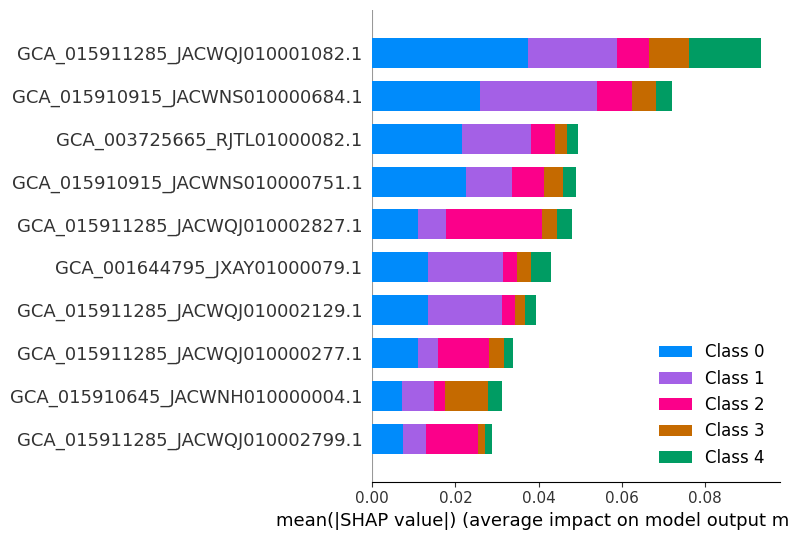

In [18]:
# Run 11/03/23
# Top 5 Sources

import warnings
warnings.filterwarnings('ignore')

target_encoding = {0: 0, 1: 1, 2:2, 3:3, 4:4}
params = {
    'objective': 'multiclass',
    'num_classes': len(target_encoding),
    'metric': 'multi_logloss',
    'verbose': -1
}

# path for the dataset
dataset_path = "dataset/dataset_pa_top5.csv"
feature_names_path = "dataset/dataset_pa_top5.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()
# Drop 'Unnamed: 0' from the feature_names
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none','pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

results_5 = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results_5

In [25]:
results_5 = results_5.round(2)
results_5.rename(columns={"Train Accuracy": "Train_Accuracy", "Test Accuracy": "Test_Accuracy"}, inplace=True)
sorted_results = results_5.sort_values(by='Test_Accuracy', ascending=False)
file_path = 'results/10_Machine_Learning/SourceTracking_Ralstonia_Table8_Dataset_Top5.csv'
sorted_results.to_csv(file_path, index=False)

 The shape of X is  5437
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.43508359456635315
Test Accuracy               =  0.10606060606060606
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.4351271334029955
Test Accuracy               =  0.07575757575757576
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.48088645071403696
Test Accuracy               =  0.07575757575757576
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  none
Train Accura

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.44270289937655133
Test Accuracy               =  0.4545454680919647
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.4197579240682689
Test Accuracy               =  0.10606060606060606
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.43517067223963773
Test Accuracy               =  0.07575757575757576
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  univariate
Train Accuracy      

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.461642284918147
Test Accuracy               =  0.06060606060606061


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.4465343157450358
Test Accuracy               =  0.42424243688583374
[[-3.22361753 -0.93617027 -0.19659949 ... -0.4386184  -0.06250398
  -0.90422187]
 [-3.22902883 -1.03376113 -0.92420424 ...  1.26824599 -3.2661847
   0.1942404 ]
 [-3.31600759 -1.06559746 -0.68146939 ...  1.18786312  4.1355421
  -0.89692443]
 ...
 [-3.3471721   1.2510689  -1.0475782  ... -0.00564951  0.02144148
  -0.00932099]
 [-3.3159883  -1.06588652 -0.68871046 ... -0.63891104  0.15801844
   0.20084057]
 [-3.30910892 -1.06665501 -0.68707662 ... -0.06140055 -0.61373308
   0.35426941]]
[-3.22361753e+00 -3.22902883e+00 -3.31600759e+00 -3.22915293e+00
 -3.31747883e+00 -3.21485582e+00 -3.29367046e+00 -3.31138739e+00
 -3.31724269e+00 -3.30256239e+00 -3.19853007e+00 -3.23858652e+00
 -3.22499786e+00 -3.22455076e+00 -3.27574806e+00 -3.2

[[-3.22361753 -0.93617027 -0.1965995  ... -0.21662291 -0.76948019
  -1.43177398]
 [-3.22902883 -1.03376113 -0.92420427 ...  0.26309506 -2.2916871
   1.7647685 ]
 [-3.31600759 -1.06559746 -0.68146939 ... -0.09046115 -1.72063538
   0.90899487]
 ...
 [-3.3471721   1.2510689  -1.0475782  ...  0.00844842  0.0061732
  -0.02383236]
 [-3.3159883  -1.06588652 -0.68871046 ... -0.7208408   0.21599364
  -0.40861303]
 [-3.30910892 -1.06665501 -0.68707662 ... -0.33843166 -0.29577359
  -0.05555244]]
[-3.22361753e+00 -3.22902883e+00 -3.31600759e+00 -3.22915293e+00
 -3.31747883e+00 -3.21485582e+00 -3.29367046e+00 -3.31138739e+00
 -3.31724269e+00 -3.30256239e+00 -3.19853007e+00 -3.23858652e+00
 -3.22499786e+00 -3.22455076e+00 -3.27574806e+00 -3.22135379e+00
 -3.31600752e+00 -3.31599970e+00 -3.23041460e+00 -3.27087375e+00
 -3.22375366e+00 -3.31599342e+00 -3.31600759e+00 -3.21455371e+00
 -3.17230446e+00 -3.19434174e+00 -3.30530118e+00 -3.31614107e+00
 -3.21455479e+00 -3.30914780e+00 -3.30233066e+00 -3.212

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.41200801730155945
Test Accuracy               =  0.4848484992980957
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.5877862595419847
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-3.22361753e+00 -9.36170270e-01 -1.96599502e-01 ... -9.14355696e-01
   1.11372684e-01  5.31255485e-01]
 [-3.22902883e+00 -1.03376113e+00 -9.24204290e-01 ...  2.73674995e+00
   2.08967301e+00  1.17482089e+00]
 [-3.31600759e+00 -1.06559746e+00 -6.81469355e-01 ... -5.54882121e-02
  -1.54192252e+00  1.39518554e+01]
 ...
 [-3.34717210e+00  1.25106890e+00 -1.04757820e+00 ... -3.29761398e-02
  -1.15501489e-02  2.20554632e-03]
 [-3.31598830e+00 -1.06588652e+00 -6.88710461e-01 ... -6.33017400e-01
  -2.12913133e-

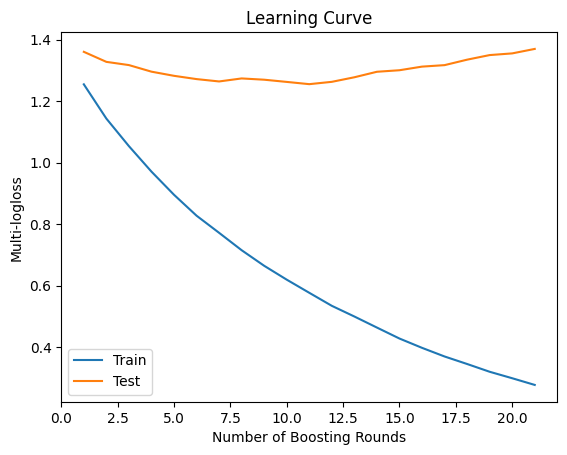

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.7366412213740458
Test Accuracy               =  0.5151515151515151


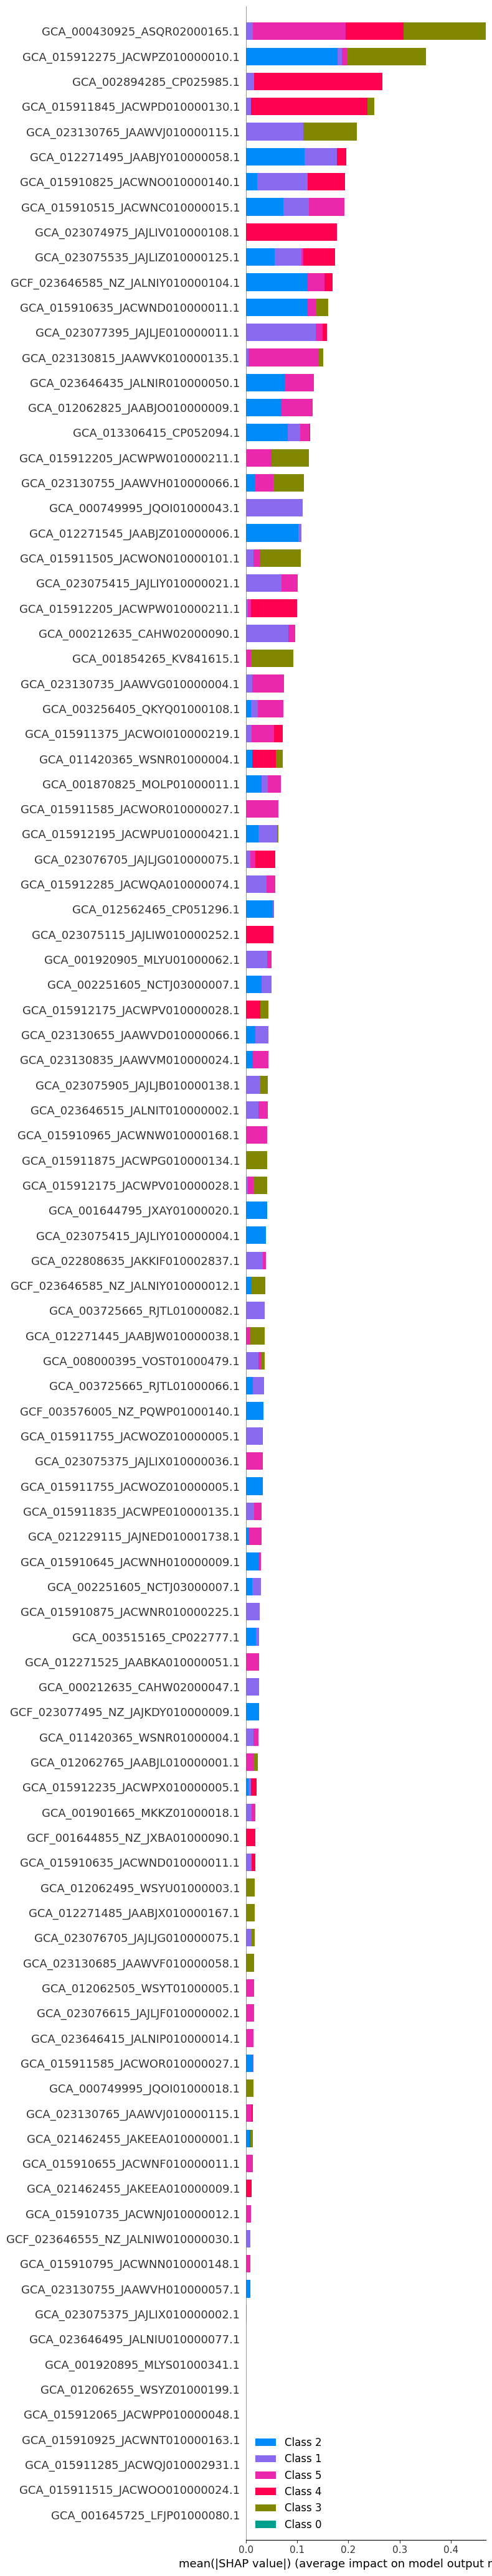

Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini        none        0.435084       0.106061
1   DecisionTreeEntropy        none        0.435127       0.075758
2          RandomForest        none        0.480886       0.075758
3                   SVM        none        0.454241       0.106061
4              lightGBM        none        0.229008       0.454545
5                   MLP        none        0.499869       0.060606
6                   cnn        none        0.442703       0.454545
7      DecisionTreeGini  univariate        0.419758       0.106061
8   DecisionTreeEntropy  univariate        0.435171       0.075758
9          RandomForest  univariate        0.473354       0.045455
10                  SVM  univariate        0.454241       0.090909
11             lightGBM  univariate        0.229008       0.469697
12                  MLP  univariate        0.461642       0.060606
13                  cnn  univariate        0.446534       0.424242
14     DecisionTreeGini         pca        0.381487       0.045455
15  DecisionTreeEntropy         pca        0.423938       0.075758
16         RandomForest         pca        0.538271       0.075758
17                  SVM         pca        0.446578       0.106061
18             lightGBM         pca        0.587786       0.469697
19                  MLP         pca        0.442703       0.075758
20                  cnn         pca        0.412008       0.484848

In [18]:
# Run 11/03/23
# Top 5 Sources

import warnings
warnings.filterwarnings('ignore')

target_encoding = {0: 0, 1: 1, 2:2, 3:3, 4:4, 5:5}
params = {
    'objective': 'multiclass',
    'num_classes': len(target_encoding),
    'metric': 'multi_logloss',
    'verbose': -1
}

# path for the dataset
dataset_path = "dataset/dataset_ralstonia_pa_top5.csv"
feature_names_path = "dataset/dataset_pa_top5.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()
# Drop 'Unnamed: 0' from the feature_names
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none','univariate','pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','lightGBM','MLP','cnn'] # 'XGBoost', Default ML Models

results_5 = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results_5

In [17]:
results_5

Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini        none        0.416667          0.425
1   DecisionTreeEntropy        none        0.423077          0.425
2          RandomForest        none        0.487179          0.550
3                   SVM        none        0.519231          0.450
4               XGBoost        none        0.467949          0.425
5              lightGBM        none        0.455128          0.425
6                   MLP        none        0.461538          0.525
7                   cnn        none        0.435897          0.500
8      DecisionTreeGini  univariate        0.410256          0.450
9   DecisionTreeEntropy  univariate        0.423077          0.425
10         RandomForest  univariate        0.512821          0.550
11                  SVM  univariate        0.512821          0.400
12              XGBoost  univariate        0.480769          0.500
13             lightGBM  univariate        0.410256          0.375
14                  MLP  univariate        0.506410          0.475
15                  cnn  univariate        0.410256          0.500
16     DecisionTreeGini         pca        0.416667          0.425
17  DecisionTreeEntropy         pca        0.461538          0.350
18         RandomForest         pca        0.570513          0.625
19                  SVM         pca        0.448718          0.550
20              XGBoost         pca        0.467949          0.575
21             lightGBM         pca        0.910256          0.600
22                  MLP         pca        0.410256          0.575
23                  cnn         pca        0.480769          0.550

In [18]:
target_encoding = {0: 0, 1: 1, 2:2}
params = {
    'objective': 'multiclass',
    'num_classes': len(target_encoding),
    'metric': 'multi_logloss',
    'verbose': -1
}

 The shape of X is  2185
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.5116279069767442
Test Accuracy               =  0.3333333333333333
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.5426356589147286
Test Accuracy               =  0.48484848484848486
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.5503875968992248
Test Accuracy               =  0.5757575757575758
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  none
Train Accuracy  

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  none
Train Accuracy              =  0.5658914728682171
Test Accuracy               =  0.6666666666666666


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.4961240192254384
Test Accuracy               =  0.5757575631141663
[[-1.53597414 -1.63961801 -1.09146098 ... -0.03384402  0.02885385
   0.03113649]
 [-1.54856807 -1.06641901 -0.77241266 ... -0.02062862 -0.19426672
  -0.08740513]
 [-1.54877496 -1.06243743 -0.76953857 ... -0.00441523 -0.09301026
  -0.04554731]
 ...
 [-1.46349813 -0.34940638 -0.21157775 ... -0.70746046  0.14301061
  -1.15315609]
 [-1.42984546 -0.29747174 -0.25389484 ... -1.14117967  0.48115432
   0.1041619 ]
 [-1.5486804  -1.06228528 -0.76940778 ... -0.00445913 -0.09397044
  -0.04600865]]
[-1.53597414e+00 -1.54856807e+00 -1.54877496e+00 -1.28362946e+00
 -1.31559905e+00 -1.38311497e+00 -1.55033358e+00 -1.54934371e+00
 -1.54889645e+00  6.87453306e-02 -1.54868040e+00 -1.52439718e+00
 -1.54812288e+00 -1.54885519e+00 -1.35298399e+00 -1.550644

[[-1.53597414 -1.63961801 -1.09146098 ... -0.03384348  0.02886006
   0.03118428]
 [-1.54856807 -1.06641901 -0.77241266 ... -0.02055725 -0.19425726
  -0.08741727]
 [-1.54877496 -1.06243743 -0.76953857 ... -0.00437774 -0.09300245
  -0.04554611]
 ...
 [-1.46349813 -0.34940638 -0.21157775 ... -0.70694299  0.14223189
  -1.157526  ]
 [-1.42984546 -0.29747174 -0.25389484 ... -1.13969592  0.48105373
   0.09917754]
 [-1.5486804  -1.06228528 -0.76940778 ... -0.0044236  -0.09396153
  -0.04600613]]
[-1.53597414e+00 -1.54856807e+00 -1.54877496e+00 -1.28362946e+00
 -1.31559905e+00 -1.38311497e+00 -1.55033358e+00 -1.54934371e+00
 -1.54889645e+00  6.87453306e-02 -1.54868040e+00 -1.52439718e+00
 -1.54812288e+00 -1.54885519e+00 -1.35298399e+00 -1.55064425e+00
 -1.55806373e+00 -1.54868040e+00 -1.39067908e+00  1.75363228e+00
 -1.71238909e+00 -1.71612511e+00 -1.55152765e+00 -1.54882182e+00
 -1.60375590e+00 -1.46147689e+00 -1.54882182e+00 -1.54879163e+00
 -1.48833195e+00 -1.54877508e+00 -1.36271881e+00 -1.5

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.5658914546171824
Test Accuracy               =  0.5454545617103577
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.7575757575757576
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-1.53597414 -1.63961801 -1.09146098 ... -0.03378524  0.02884703
   0.03107204]
 [-1.54856807 -1.06641901 -0.77241266 ... -0.02036169 -0.19428133
  -0.08814923]
 [-1.54877496 -1.06243743 -0.76953857 ... -0.00425583 -0.09301865
  -0.04598068]
 ...
 [-1.46349813 -0.34940638 -0.21157775 ... -0.71211492  0.14351574
  -1.13970887]
 [-1.42984546 -0.29747174 -0.25389484 ... -1.14099783  0.4815104
   0.10064933]
 [-1.5486804  -1.06228528 -0.76940778 ... -0.00431028 -0.09397715
  -0.04642676]]
[-1.53597414e+00 -1.

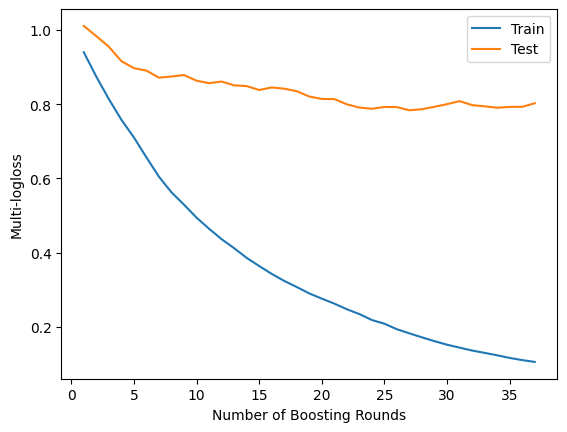

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  1.0
Test Accuracy               =  0.696969696969697


Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.511628       0.333333
1   DecisionTreeEntropy      none        0.542636       0.484848
2          RandomForest      none        0.550388       0.575758
3                   SVM      none        0.596899       0.545455
4              lightGBM      none        0.503876       0.545455
5                   MLP      none        0.565891       0.666667
6                   cnn      none        0.496124       0.575758
7      DecisionTreeGini       pca        0.635659       0.545455
8   DecisionTreeEntropy       pca        0.496124       0.484848
9          RandomForest       pca        0.627907       0.666667
10                  SVM       pca        0.550388       0.666667
11             lightGBM       pca        1.000000       0.757576
12                  MLP       pca        0.488372       0.545455
13                  cnn       pca        0.565891       0.545455

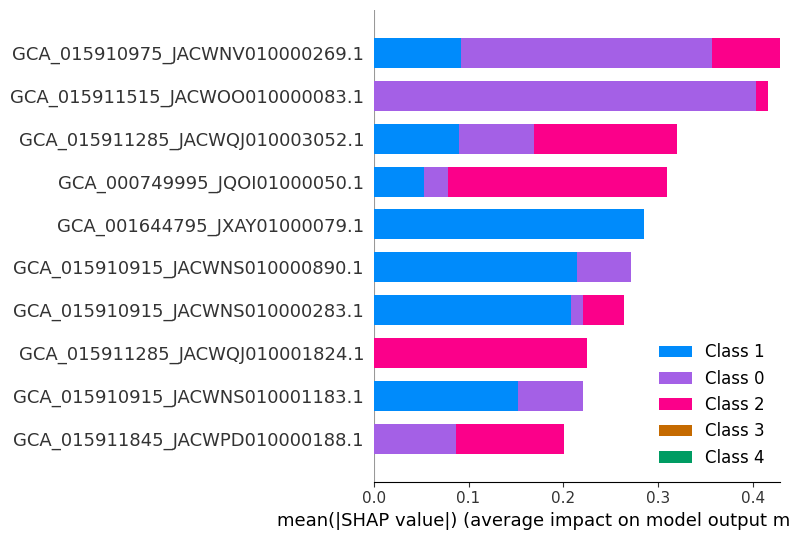

In [21]:
# Run 11/03/23
# Top 3 Sources

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "dataset/dataset_pa_top3.csv"

params = {
    'objective': 'multiclass',
    'num_classes': len(target_encoding),
    'metric': 'multi_logloss',
    'verbose': -1
}

feature_names_path = "dataset/dataset_pa_top3.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()
# Drop 'Unnamed: 0' from the feature_names
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none', 'pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

results_3 = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results_3

In [22]:
results_3

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.511628       0.333333
1   DecisionTreeEntropy      none        0.542636       0.484848
2          RandomForest      none        0.550388       0.575758
3                   SVM      none        0.596899       0.545455
4              lightGBM      none        0.503876       0.545455
5                   MLP      none        0.565891       0.666667
6                   cnn      none        0.496124       0.575758
7      DecisionTreeGini       pca        0.635659       0.545455
8   DecisionTreeEntropy       pca        0.496124       0.484848
9          RandomForest       pca        0.627907       0.666667
10                  SVM       pca        0.550388       0.666667
11             lightGBM       pca        1.000000       0.757576
12                  MLP       pca        0.488372       0.545455
13                  cnn       pca        0.565891       0.545455

In [24]:
results_3 = results_3.round(2)
results_3.rename(columns={"Train Accuracy": "Train_Accuracy", "Test Accuracy": "Test_Accuracy"}, inplace=True)
sorted_results = results_3.sort_values(by='Test_Accuracy', ascending=False)
file_path = 'results/10_Machine_Learning/SourceTracking_Ralstonia_Table9_Dataset_Top3.csv'
sorted_results.to_csv(file_path, index=False)

 The shape of X is  5437
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.5763235806339254
Test Accuracy               =  0.15151515151515152
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.5612591431556949
Test Accuracy               =  0.15151515151515152
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.6259143155694881
Test Accuracy               =  0.13636363636363635
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  none
Train Accuracy

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.5919104814529419
Test Accuracy               =  0.6363636255264282
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.5801549982584465
Test Accuracy               =  0.15151515151515152
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.5839864158829676
Test Accuracy               =  0.15151515151515152
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  univariate
Train Accuracy        

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.6412399860675723
Test Accuracy               =  0.16666666666666666


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.5919104814529419
Test Accuracy               =  0.5151515007019043
[[-3.31662634e+00 -1.06663894e+00 -6.93841050e-01 ... -9.25357591e-02
   5.71743848e-02 -2.68959519e-01]
 [-3.16453500e+00 -1.04061871e+00 -1.03907162e+00 ...  2.07334599e-02
   1.33900118e-03  1.50216705e-02]
 [-3.12445178e+00 -1.09686100e+00 -8.30714776e-01 ... -4.96630239e-01
   1.58204286e-01  2.79220203e-01]
 ...
 [-3.31643521e+00 -1.06639081e+00 -6.88924612e-01 ... -2.45121029e+00
   1.45866193e-01 -1.70065296e+00]
 [-4.59322949e-01  1.14435176e+00  1.61453512e+01 ... -4.14657330e-03
   1.62786852e-03  7.98215761e-04]
 [-3.23208670e+00 -9.72929695e-01 -1.99330876e-01 ... -7.61311931e-02
  -3.91193556e-01 -3.34457859e-01]]
[-3.31662634e+00 -3.16453500e+00 -3.12445178e+00 -3.26671223e+00
 -3.31643014e+00 -3.31785324e+00 -3.31

[[-3.31662634e+00 -1.06663894e+00 -6.93841060e-01 ... -6.43048699e-01
  -1.55181158e-01  1.35563374e-01]
 [-3.16453500e+00 -1.04061871e+00 -1.03907162e+00 ...  5.52566997e-02
   3.08958001e-03  4.39646753e-02]
 [-3.12445178e+00 -1.09686100e+00 -8.30714775e-01 ...  2.79170499e-01
   9.90375750e-02  3.30552943e-01]
 ...
 [-3.31643521e+00 -1.06639081e+00 -6.88924626e-01 ...  4.87039794e+00
  -8.39818802e+00  7.98474446e+00]
 [-4.59322949e-01  1.14435176e+00  1.61453512e+01 ...  1.15032082e-02
  -2.13164019e-03  1.71646321e-03]
 [-3.23208670e+00 -9.72929695e-01 -1.99330872e-01 ... -4.45527576e-01
  -6.83580853e-04 -3.36615689e-01]]
[-3.31662634e+00 -3.16453500e+00 -3.12445178e+00 -3.26671223e+00
 -3.31643014e+00 -3.31785324e+00 -3.31769886e+00 -3.24936951e+00
 -3.23165944e+00 -3.30970045e+00 -3.27617163e+00 -3.30931795e+00
 -3.24400415e+00 -3.17529371e+00 -3.31643521e+00 -3.31030421e+00
 -3.22306431e+00 -3.10737813e+00 -3.23050623e+00 -3.23416069e+00
 -3.31643508e+00 -3.31651691e+00 -3.297

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.5842911998430887
Test Accuracy               =  0.6212121248245239
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.7404580152671756
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-3.31662634e+00 -1.06663894e+00 -6.93841057e-01 ...  1.13332736e-01
   3.44553005e-03  1.48896223e-01]
 [-3.16453500e+00 -1.04061871e+00 -1.03907162e+00 ... -7.90960757e-03
  -9.92464738e-03 -1.50705233e-02]
 [-3.12445178e+00 -1.09686100e+00 -8.30714768e-01 ... -7.12988844e-01
  -1.56359234e-01 -1.29785600e-01]
 ...
 [-3.31643521e+00 -1.06639081e+00 -6.88924669e-01 ...  1.66373018e+00
  -3.40164210e-01 -5.47856815e+00]
 [-4.59322949e-01  1.14435176e+00  1.61453512e+01 ... -1.03931900e-02
   4.57647363e-0

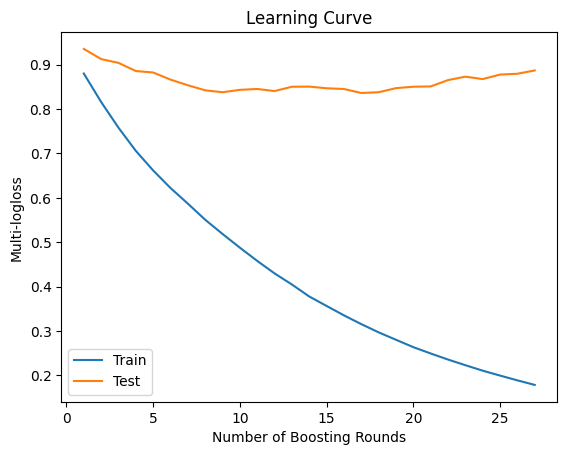

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.9427480916030534
Test Accuracy               =  0.6515151515151515


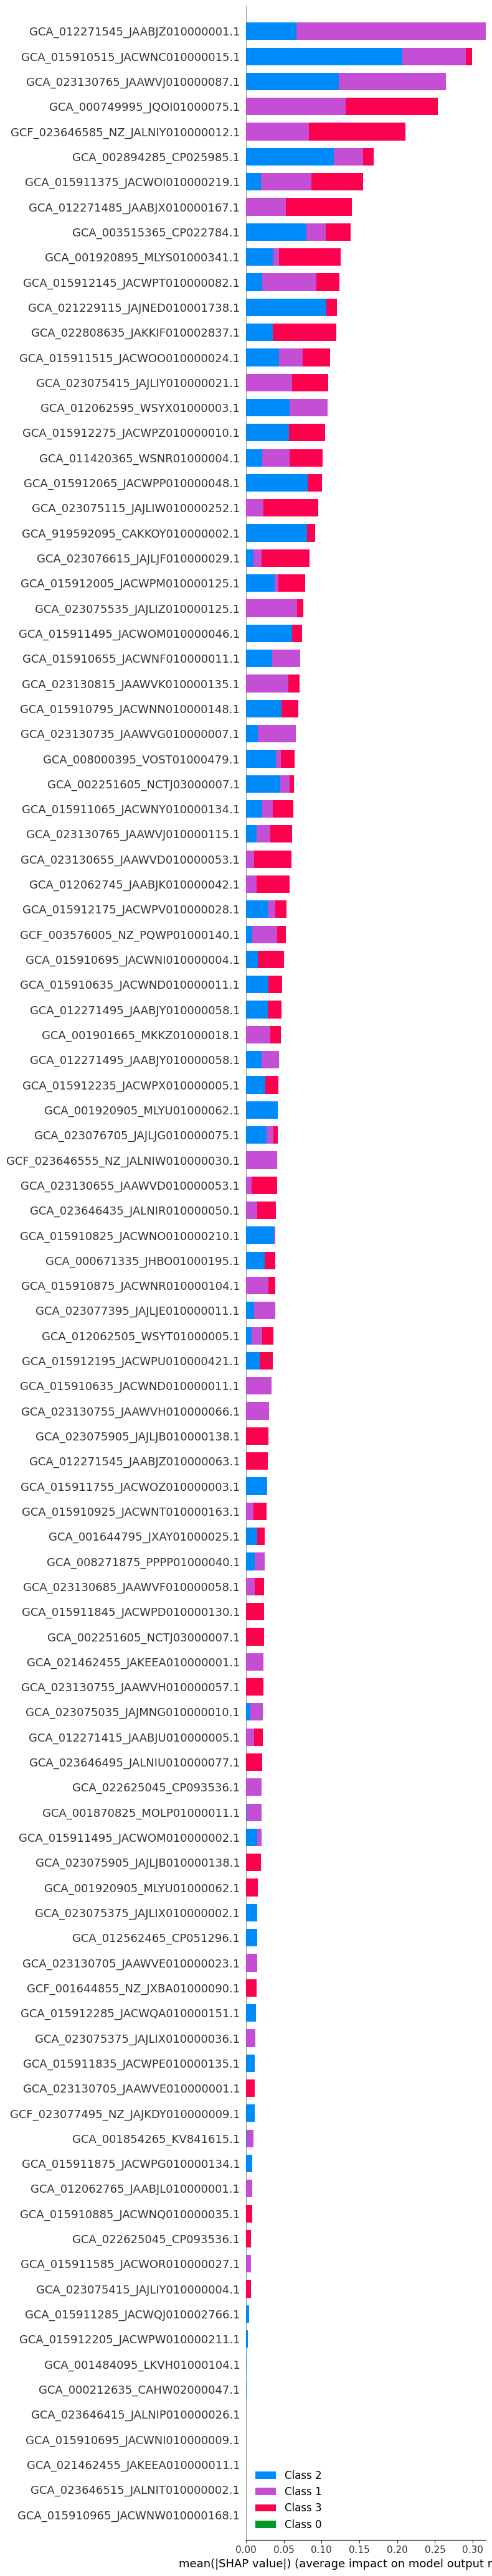

Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini        none        0.576324       0.151515
1   DecisionTreeEntropy        none        0.561259       0.151515
2          RandomForest        none        0.625914       0.136364
3                   SVM        none        0.591606       0.151515
4              lightGBM        none        0.587786       0.590909
5                   MLP        none        0.625958       0.121212
6                   cnn        none        0.591910       0.636364
7      DecisionTreeGini  univariate        0.580155       0.151515
8   DecisionTreeEntropy  univariate        0.583986       0.151515
9          RandomForest  univariate        0.629789       0.151515
10                  SVM  univariate        0.610719       0.151515
11             lightGBM  univariate        0.572519       0.590909
12                  MLP  univariate        0.641240       0.166667
13                  cnn  univariate        0.591910       0.515152
14     DecisionTreeGini         pca        0.564612       0.136364
15  DecisionTreeEntropy         pca        0.538053       0.151515
16         RandomForest         pca        0.625871       0.121212
17                  SVM         pca        0.591606       0.166667
18             lightGBM         pca        0.740458       0.606061
19                  MLP         pca        0.522901       0.136364
20                  cnn         pca        0.584291       0.621212

In [20]:
# Run 11/03/23
# Top 3 Sources

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "dataset/dataset_ralstonia_pa_top3.csv"
target_encoding = {0: 0, 1: 1, 2:2, 3:3}
params = {
    'objective': 'multiclass',
    'num_classes': len(target_encoding),
    'metric': 'multi_logloss',
    'verbose': -1
}

feature_names_path = "dataset/dataset_pa_top3.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()
# Drop 'Unnamed: 0' from the feature_names
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none','univariate','pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','lightGBM','MLP','cnn'] # Default ML Models

results_3 = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results_3

In [32]:
results_3

Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini        none        0.542636       0.363636
1   DecisionTreeEntropy        none        0.550388       0.484848
2          RandomForest        none        0.550388       0.575758
3                   SVM        none        0.596899       0.545455
4               XGBoost        none        0.581395       0.484848
5              lightGBM        none        0.496124       0.515152
6                   MLP        none        0.565891       0.666667
7                   cnn        none        0.589147       0.636364
8      DecisionTreeGini  univariate        0.542636       0.454545
9   DecisionTreeEntropy  univariate        0.558140       0.454545
10         RandomForest  univariate        0.589147       0.515152
11                  SVM  univariate        0.596899       0.545455
12              XGBoost  univariate        0.542636       0.515152
13             lightGBM  univariate        0.496124       0.515152
14                  MLP  univariate        0.604651       0.545455
15                  cnn  univariate        0.534884       0.636364
16     DecisionTreeGini         pca        0.596899       0.545455
17  DecisionTreeEntropy         pca        0.534884       0.515152
18         RandomForest         pca        0.635659       0.666667
19                  SVM         pca        0.550388       0.696970
20              XGBoost         pca        0.643411       0.696970
21             lightGBM         pca        0.961240       0.636364
22                  MLP         pca        0.480620       0.545455
23                  cnn         pca        0.457364       0.484848

#### Ralstonia - One vs All

***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.7487599206349206
Test Accuracy               =  0.7291666666666666
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.7540509259259259
Test Accuracy               =  0.7083333333333334
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.7804232804232805
Test Accuracy               =  0.75
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  univariate
Train Accuracy              =  0

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.7540509259259259
Test Accuracy               =  0.5625


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.6808862487475077
Test Accuracy               =  0.8125
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  pca
Train Accuracy              =  0.5920138888888888
Test Accuracy               =  0.7291666666666666
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  pca
Train Accuracy              =  0.6598048941798942
Test Accuracy               =  0.7291666666666666
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  pca
Train Accuracy              =  0.753968253968254
Te

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.6966765920321146
Test Accuracy               =  0.7916666865348816
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.9947643979057592
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.331723	valid_1's multi_logloss: 0.490425
[20]	training's multi_logloss: 0.210122	valid_1's multi_logloss: 0.422558
[30]	training's multi_logloss: 0.128537	valid_1's multi_logloss: 0.399603
[40]	training's multi_logloss: 0.0850037	valid_1's multi_logloss: 0.362482
[50]	training's multi_logloss: 0.05611	valid_1's multi_logloss: 0.359768
Early stopping, best iteration is:
[43]	training's multi_logloss: 0.0741855	vali

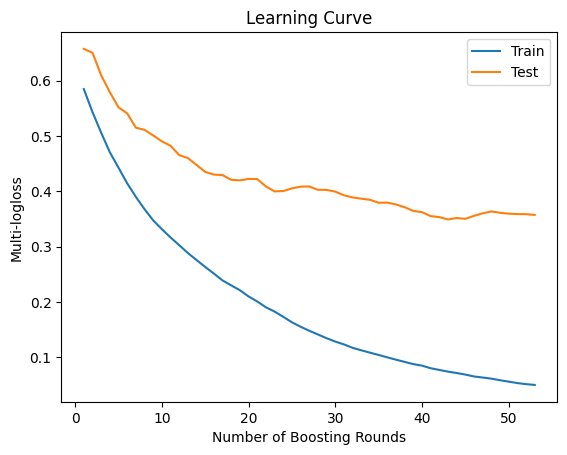

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  1.0
Test Accuracy               =  0.7708333333333334


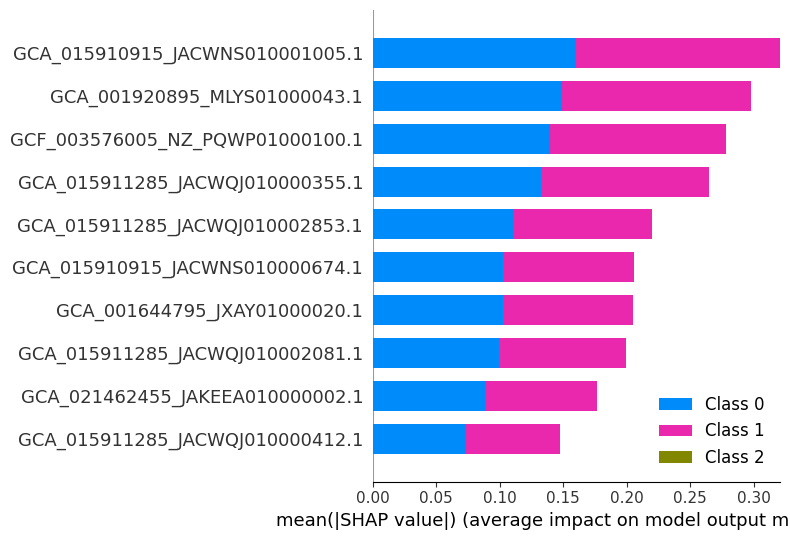

                  Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini  univariate        0.748760       0.729167
1   DecisionTreeEntropy  univariate        0.754051       0.708333
2          RandomForest  univariate        0.780423       0.750000
3                   SVM  univariate        0.748843       0.750000
4               XGBoost  univariate        0.738343       0.708333
5              lightGBM  univariate        0.774869       0.729167
6                   MLP  univariate        0.754051       0.562500
7                   cnn  univariate        0.680886       0.812500
8      DecisionTreeGini         pca        0.592014       0.729167
9   DecisionTreeEntropy         pca        0.659805       0.729167
10         RandomForest         pca        0.753968       0.791667
11                  SVM         pca        0.680638       0.770833
12              XGBoost         pca        0.691386       0.770833
13             lightGBM         pca        0.994764       0.79

***********************************************************************************
Model                       =  MLP
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.8062996031746031
Test Accuracy               =  0.8333333333333334


***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.7694279154141744
Test Accuracy               =  0.8541666865348816
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  pca
Train Accuracy              =  0.7279265873015873
Test Accuracy               =  0.8333333333333334
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  pca
Train Accuracy              =  0.7330522486772487
Test Accuracy               =  0.6875
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  pca
Train Accuracy              =  0.7905092592592592
T

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.7590112487475077
Test Accuracy               =  0.8333333134651184
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.853505291005291
The Best Performing Combination is: Model:  SVM  and Feature Selection:  univariate
***********************************************************************************
Model                       =  SVM
Feature Selection Criteria  =  univariate
Train Accuracy              =  0.853505291005291
Test Accuracy               =  0.8333333333333334
                  Model   Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini  univariate        0.795883       0.875000
1   DecisionTreeEntropy  univariate        0.785384       0.854167
2          RandomForest  univariate        0.7853

ValueError: at least one array or dtype is required

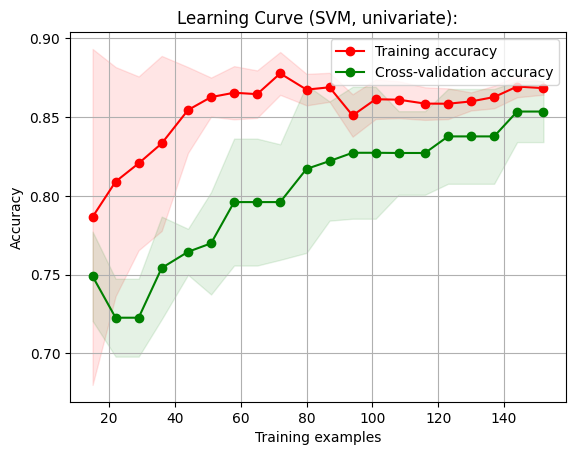

In [17]:
# Run 11/14/2023
# One vs All for Top 10

import warnings
warnings.filterwarnings('ignore')
dataset_path = "dataset/dataset_pa_top10.csv"
feature_names_path = "dataset/dataset_pa_top10.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()

if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none', 'univariate', 'pca']  # Default Feature Selection Metrics 
models = ['DecisionTreeGini', 'DecisionTreeEntropy', 'RandomForest', 'SVM', 'XGBoost', 'lightGBM', 'MLP', 'cnn']  # Default ML Models

# Assuming the target variable is 'target'
target_variable = 'target'

# Initialize the dictionary to store the best models
best_models = {}

# Loop through each class for one-vs-all classification
for class_label in range(10):
    # Update target encoding for one-vs-all classification
    target_encoding = {class_label: 1, **{label: 0 for label in range(5) if label != class_label}}

    # Run the pipeline for this specific Source
    results_df = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
    print(results_df)

    # Store the best performing model
    best_row = results_df.loc[results_df['Test_Accuracy'].idxmax()]
    best_models[class_label] = {
        'Model': best_row['Model'],
        'Selection': best_row['Selection'],
        'Train_Accuracy': best_row['Train_Accuracy'],
        'Test_Accuracy': best_row['Test_Accuracy']
    }

# Display the best models for each class
for class_label, model_info in best_models.items():
    print(f"Best Model for Class {class_label}: {model_info['Model']} - Selection: {model_info['Selection']} - Train Accuracy: {model_info['Train_Accuracy']} - Test Accuracy: {model_info['Test_Accuracy']}")

 The shape of X is  2185
[[-2.7029542  -1.38168417 -1.35873011 ...  0.06416117 -0.01565439
   0.13040124]
 [-2.83546138 -1.48645323 -0.20770943 ...  0.04942479  1.7061157
  -0.62481696]
 [-2.77699648 -1.45765518 -1.11678844 ... -1.19476749 -0.1295804
  -0.24922138]
 ...
 [-2.75302088 -1.51242767 -0.95935653 ... -3.06533351  0.67776695
   5.03149936]
 [-2.78923562 -1.44966098 -1.11856471 ...  0.20276074  0.02624789
   0.13238825]
 [-2.87713899 -1.513332   -0.95739506 ...  0.15152433 -0.01404976
   0.11546831]]
[ -2.7029542   -2.83546138  -2.77699648  -2.87543233  -2.77921859
  -2.87721487  -2.86618738  -2.77557497  -2.7872505   -2.76823391
  -2.8769923   -2.87750095  -2.81618915  -2.80060658  -2.64401351
  -2.84838558  -2.81781436  -2.87673118  -2.87670806  -2.76369052
  -2.85480679 355.80277553  -2.80455742  -2.78327275  -2.79112632
  -2.81542524  -2.795499    -2.87669139  -2.8458869   -2.87670806
  -2.77332388  -2.79194372  -2.78092731  -2.88274994  -0.39822067
  -2.79402696  -2.78580

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.682170550028483
Test Accuracy               =  0.6666666865348816
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.9302325581395349
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-2.7029542  -1.38168417 -1.35873011 ...  0.0633779  -0.01639589
   0.1281984 ]
 [-2.83546138 -1.48645323 -0.20770943 ...  0.15095461  1.5746407
  -0.44142791]
 [-2.77699648 -1.45765518 -1.11678844 ... -1.19235301 -0.1210921
  -0.23766785]
 ...
 [-2.75302088 -1.51242767 -0.95935653 ... -2.99296498  0.6037506
   5.16870038]
 [-2.78923562 -1.44966098 -1.11856471 ...  0.20519939  0.02082618
   0.14744011]
 [-2.87713899 -1.513332   -0.95739506 ...  0.15121516 -0.01840288
   0.11671855]]
[ -2.7029542   -2.83546

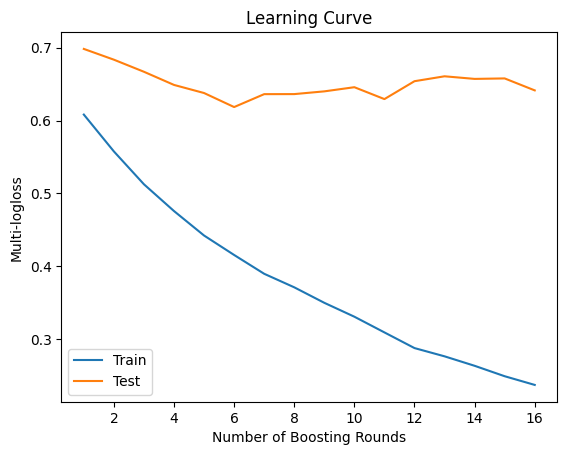

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.9224806201550387
Test Accuracy               =  0.6060606060606061
Gene Families of most importance: ['GCA_015911285_JACWQJ010002969.1', 'GCA_001645725_LFJP01000136.1', 'GCA_015911285_JACWQJ010002998.1', 'GCA_003515185_CP022788.1', 'GCA_000749995_JQOI01000075.1', 'GCA_015910915_JACWNS010000542.1', 'GCA_015911285_JACWQJ010001413.1', 'GCA_015911285_JACWQJ010001466.1', 'GCA_015910915_JACWNS010000405.1', 'GCA_003725665_RJTL01000035.1', 'GCA_015911285_JACWQJ010002568.1', 'GCA_015911285_JACWQJ010002939.1', 'GCA_015911285_JACWQJ010001385.1', 'GCA_015911285_JACWQJ010002054.1', 'GCA_015911285_JACWQJ010002917.1', 'GCA_015911375_JACWOI010000219.1', 'GCA_023130755_JAAWVH010000066.1', 'GCA_023075415_JAJLIY010000012.1', 'GCA_015911285_JACWQJ010002766.1', 'GCA_000671315_JHAM01000140.1', 'GCA_015910915_JACWNS0100

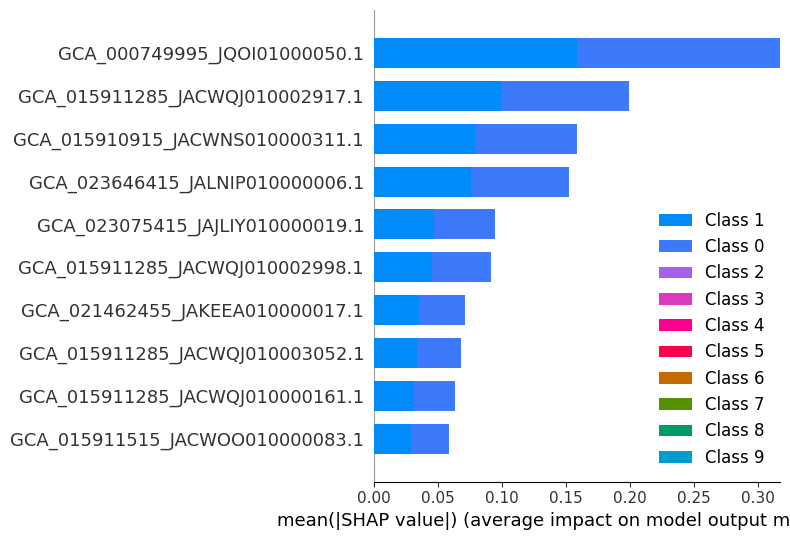

                 Model Selection  Train_Accuracy  Test_Accuracy
0     DecisionTreeGini       pca        0.573643       0.575758
1  DecisionTreeEntropy       pca        0.573643       0.515152
2         RandomForest       pca        0.744186       0.696970
3                  SVM       pca        0.635659       0.666667
4              XGBoost       pca        0.666667       0.606061
5             lightGBM       pca        0.930233       0.696970
6                  MLP       pca        0.705426       0.666667
7                  cnn       pca        0.682171       0.666667
 The shape of X is  2185
[[-8.59818479e-01 -2.59123687e-01  1.29218356e+01 ...  3.40562254e-04
  -5.85817128e-05  1.82809445e-03]
 [-2.88414531e+00 -1.51855483e+00 -9.87007426e-01 ... -7.12361855e-01
   6.83231162e-01 -7.01025908e-01]
 [-2.79840171e+00 -1.54290540e+00 -1.37347668e+00 ... -4.61078114e-02
  -7.91394493e-02 -1.93758316e-01]
 ...
 [-2.87295187e+00 -1.49789994e+00 -1.06300676e+00 ... -1.23413254e-01
  -6.1019

[[-8.59818479e-01 -2.59123687e-01  1.29218356e+01 ...  3.39837798e-04
  -5.73195798e-05  1.82797897e-03]
 [-2.88414531e+00 -1.51855483e+00 -9.87007426e-01 ... -7.12347477e-01
   6.83972413e-01 -7.00826006e-01]
 [-2.79840171e+00 -1.54290540e+00 -1.37347668e+00 ... -4.61113930e-02
  -7.93025595e-02 -1.93698260e-01]
 ...
 [-2.87295187e+00 -1.49789994e+00 -1.06300676e+00 ... -1.23391314e-01
  -6.07887806e-02 -2.31328752e-01]
 [-2.71965872e+00 -1.40052389e+00 -1.48027467e+00 ...  2.43510574e-02
  -1.64236944e-02  2.85379804e-03]
 [-2.88376809e+00 -1.51876782e+00 -1.05173785e+00 ... -3.59397418e-02
  -3.89151208e-02 -7.34733373e-02]]
[ -0.85981848  -2.88414531  -2.79840171  -2.77394453  -2.88369713
  -2.75799237  -2.88369263  -2.88369713  -2.88379134  -2.88529146
  -2.78984992  -2.80807667  -2.88015004  -2.85024986  -2.83092125
  -2.80313423  -2.82033799  -2.88374368  -2.68231656  -2.77484794
  -2.88369263  -2.88375047  -2.5142852   -2.88375803  -2.62282639
  -2.8184752   -2.58959034  -2.857

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.6589147448539734
Test Accuracy               =  0.6666666865348816
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.7829457364341085
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-8.59818479e-01 -2.59123687e-01  1.29218356e+01 ...  3.39882060e-04
  -5.68169080e-05  1.82811409e-03]
 [-2.88414531e+00 -1.51855483e+00 -9.87007426e-01 ... -7.12729822e-01
   6.83807743e-01 -7.01767878e-01]
 [-2.79840171e+00 -1.54290540e+00 -1.37347668e+00 ... -4.60763804e-02
  -7.92190386e-02 -1.93840800e-01]
 ...
 [-2.87295187e+00 -1.49789994e+00 -1.06300676e+00 ... -1.23468319e-01
  -6.09227881e-02 -2.31447246e-01]
 [-2.71965872e+00 -1.40052389e+00 -1.48027467e+00 ...  2.43348090e-02
  -1.64855362e-0

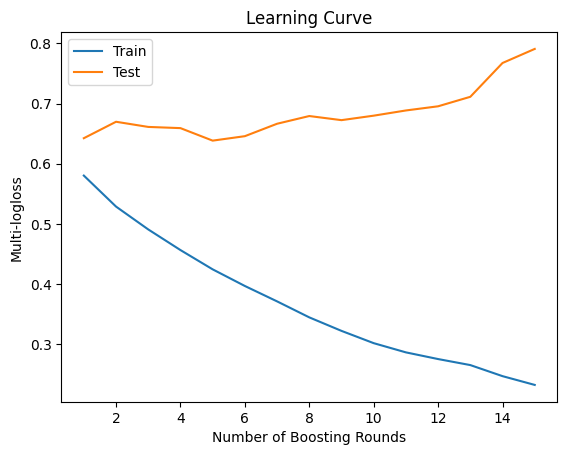

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.8062015503875969
Test Accuracy               =  0.696969696969697
Gene Families of most importance: ['GCA_015911285_JACWQJ010002969.1', 'GCA_015911285_JACWQJ010001990.1', 'GCA_015911285_JACWQJ010002998.1', 'GCA_015911285_JACWQJ010002709.1', 'GCA_001920895_MLYS01000265.1', 'GCA_000749995_JQOI01000075.1', 'GCA_001645725_LFJP01000080.1', 'GCA_015911285_JACWQJ010001413.1', 'GCA_015911285_JACWQJ010001644.1', 'GCA_015910915_JACWNS010000405.1', 'GCA_015911285_JACWQJ010001211.1', 'GCA_015911285_JACWQJ010002395.1', 'GCA_015911285_JACWQJ010002568.1', 'GCA_015910915_JACWNS010000946.1', 'GCA_015911285_JACWQJ010001730.1', 'GCA_015911285_JACWQJ010001385.1', 'GCA_015910915_JACWNS010000786.1', 'GCA_015911285_JACWQJ010002917.1', 'GCA_000749995_JQOI01000070.1', 'GCA_023130755_JAAWVH010000066.1', 'GCA_015910965_JACW

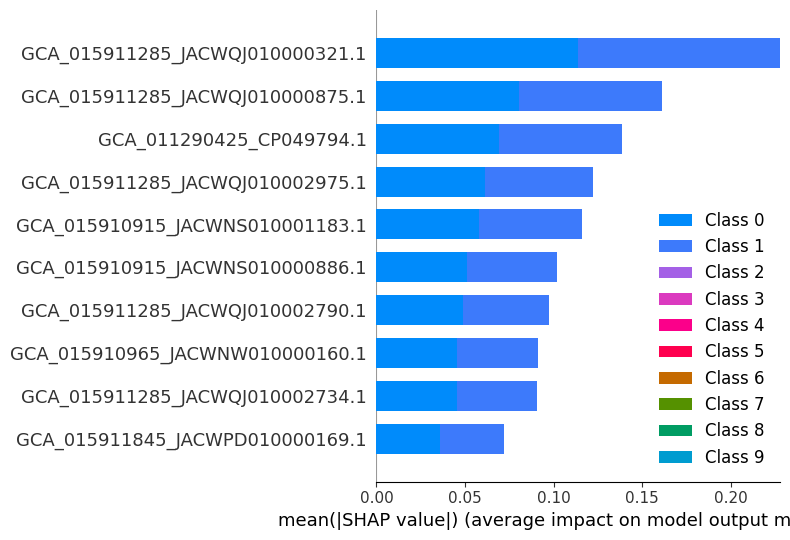

                 Model Selection  Train_Accuracy  Test_Accuracy
0     DecisionTreeGini       pca        0.689922       0.727273
1  DecisionTreeEntropy       pca        0.658915       0.666667
2         RandomForest       pca        0.759690       0.727273
3                  SVM       pca        0.666667       0.696970
4              XGBoost       pca        0.682171       0.696970
5             lightGBM       pca        0.782946       0.636364
6                  MLP       pca        0.635659       0.606061
7                  cnn       pca        0.658915       0.666667
 The shape of X is  0


ValueError: at least one array or dtype is required

In [14]:
# Run 11/14/2023
# One vs All for Top 10

import warnings
warnings.filterwarnings('ignore')
dataset_path = "dataset/dataset_pa_top3.csv"
feature_names_path = "dataset/dataset_pa_top3.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()

if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['pca']  # Default Feature Selection Metrics 
models = ['DecisionTreeGini', 'DecisionTreeEntropy', 'RandomForest', 'SVM', 'XGBoost', 'lightGBM', 'MLP', 'cnn']  # Default ML Models

# Assuming the target variable is 'target'
target_variable = 'target'

# Initialize the dictionary to store the best models
best_models = {}

# Loop through each class for one-vs-all classification
for class_label in range(3):
    # Update target encoding for one-vs-all classification
    target_encoding = {class_label: 1, **{label: 0 for label in range(3) if label != class_label}}

    # Run the pipeline for this specific Source
    results_df = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
    print(results_df)

    # Store the best performing model
    best_row = results_df.loc[results_df['Test_Accuracy'].idxmax()]
    best_models[class_label] = {
        'Model': best_row['Model'],
        'Selection': best_row['Selection'],
        'Train_Accuracy': best_row['Train_Accuracy'],
        'Test_Accuracy': best_row['Test_Accuracy']
    }

# Display the best models for each class
for class_label, model_info in best_models.items():
    print(f"Best Model for Class {class_label}: {model_info['Model']} - Selection: {model_info['Selection']} - Train Accuracy: {model_info['Train_Accuracy']} - Test Accuracy: {model_info['Test_Accuracy']}")

In [22]:
# Test 11/03/23
# Top 10 Sources

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "dataset/dataset_pa_top10.csv"

feature_names_path = "dataset/dataset_pa_top10.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()
# Drop 'Unnamed: 0' from the feature_names
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5:5, 6:6, 7:7, 8:8, 9:9}

results = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results

[[-1.28895885 -0.88698948 -0.6365237  ... -0.06872489 -0.33717939
   0.02626483]
 [-1.35735154 -1.07810413 -0.80309584 ... -0.03030518  0.13144943
   0.01775808]
 [-1.25891185 -0.95516212 -0.61827416 ...  0.12951355 -0.04657275
  -0.00968373]
 ...
 [-1.27097699 -0.89181992 -0.64034965 ... -0.21672509 -0.46799013
   0.15357219]
 [-1.26820108 -0.84881809 -0.60507335 ... -0.1491247  -0.32047542
   0.01444454]
 [-1.29871834 -0.89918883 -0.6474905  ...  0.20668669  0.09714264
  -0.01887004]]
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  pca
Train Accuracy              =  0.3455687830687831
Test Accuracy               =  0.4375
[[-1.28895885 -0.88698948 -0.6365237  ... -0.0754003  -0.31916933
   0.01951254]
 [-1.35735154 -1.07810413 -0.80309584 ... -0.03887025  0.06626179
  -0.03337333]
 [-1.25891185 -0.95516212 -0.61827416 ...  0.04739151 -0.13065046
   0.08638719]
 ...
 [-1.

[LightGBM] [Fatal] Label must be in [0, 3), but found 4 in label


LightGBMError: Label must be in [0, 3), but found 4 in label

### Experiments with PCA 
 

#### a. Salmonella

Dummy Gene Distribution dummy_gene
0    676
1     69
Name: count, dtype: int64
 The shape of X is  4354
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.835566722501396
Test Accuracy               =  0.8456375838926175
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.8271830533137066
Test Accuracy               =  0.8053691275167785
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.9043957159535049
Test Accuracy               =  0.9060402684563759
***********************************************************************************
Model     

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.6896181503931681
Test Accuracy               =  0.9060402512550354
[[-1.86010975e+01 -2.00249251e+00 -2.46388512e+00 ...  1.22243960e+00
  -5.48042820e-01 -7.86119409e-01]
 [ 2.28229957e+01 -1.90552639e+00 -2.60904413e+00 ...  1.89803421e-02
  -3.91566766e-01 -1.15678596e+00]
 [ 2.04598854e+01 -2.97241984e+00  2.11589763e-01 ...  4.36728559e+00
  -2.84021286e+00  2.48509945e+00]
 ...
 [-1.56250918e+01 -1.75507492e+00 -1.66008634e+00 ... -1.91094203e+00
  -8.69533111e-01 -1.80777766e-01]
 [-1.61213807e+01 -1.14436108e+00 -1.15016290e+00 ...  2.76714825e+00
   1.57128807e+00 -1.23017219e+00]
 [-3.07910263e+00 -7.58901802e-01 -6.18061323e-01 ... -1.32832215e+00
   1.00012151e+00  3.25151154e+00]]
[-18.60109746  22.82299568  20.45988545 -14.53725628 -18.18094413
 -18.30030856  -6.39086099  27.14954593  -6

[[-18.60109744  -2.00249281  -2.46388523 ...   2.0212532   -0.10906021
   -0.74190979]
 [ 22.82299567  -1.90552632  -2.60904487 ...  -0.19017366   0.04123823
   -0.24991093]
 [ 20.45988537  -2.97241915   0.21158868 ...   1.94557686   1.35584919
    6.07797099]
 ...
 [-15.62509181  -1.75507481  -1.66008651 ...  -2.75688156   1.25539338
    1.9847628 ]
 [-16.12138082  -1.14436178  -1.1501618  ...  -1.15064919   1.85408921
   -3.12786109]
 [ -3.07910259  -0.75890192  -0.61806192 ...  -0.95593066   0.7662913
    3.19211833]]
[-18.60109744  22.82299567  20.45988537 -14.53725627 -18.18094413
 -18.30030856  -6.39086099  27.14954596  -6.39486424 -16.4583381
 -18.17835131  41.57907085  -6.31154873  -6.45581496  22.13666881
 -16.56804328 -15.45158457  21.64711135  -5.90664199  23.80115222
 -15.5615452   22.56383406  -6.43244273  26.33017702  -6.44405117
  -7.43281629 -17.49939757 -19.28708066  26.61487533  -6.38458372
  -4.53598542  25.89400252  25.23778607  -6.8696488  -17.74076802
  -6.2811511

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.7885302106539408
Test Accuracy               =  0.8657718300819397
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.9966442953020134
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-18.60109749  -2.00249263  -2.4638851  ...   4.35890955  -1.74459288
    0.37913528]
 [ 22.82299568  -1.90552631  -2.60904492 ...  -0.57131999  -0.61778567
   -0.21878761]
 [ 20.4598854   -2.97242032   0.21158728 ...   1.05729441   0.90042486
   -2.85980615]
 ...
 [-15.6250918   -1.75507493  -1.66008661 ...  -4.15046958   1.90211312
   -1.74417455]
 [-16.12138084  -1.14436267  -1.15016115 ...  -3.4153207   -1.4375036
    7.13992026]
 [ -3.0791026   -0.75890267  -0.61806216 ...  -3.3033911    1.64981128
 

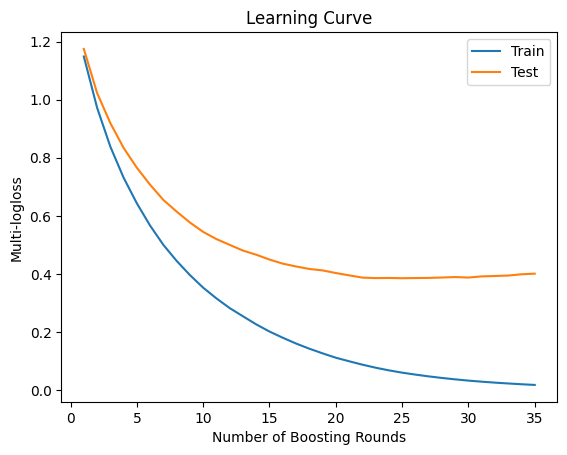

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.9983221476510067
Test Accuracy               =  0.8993288590604027


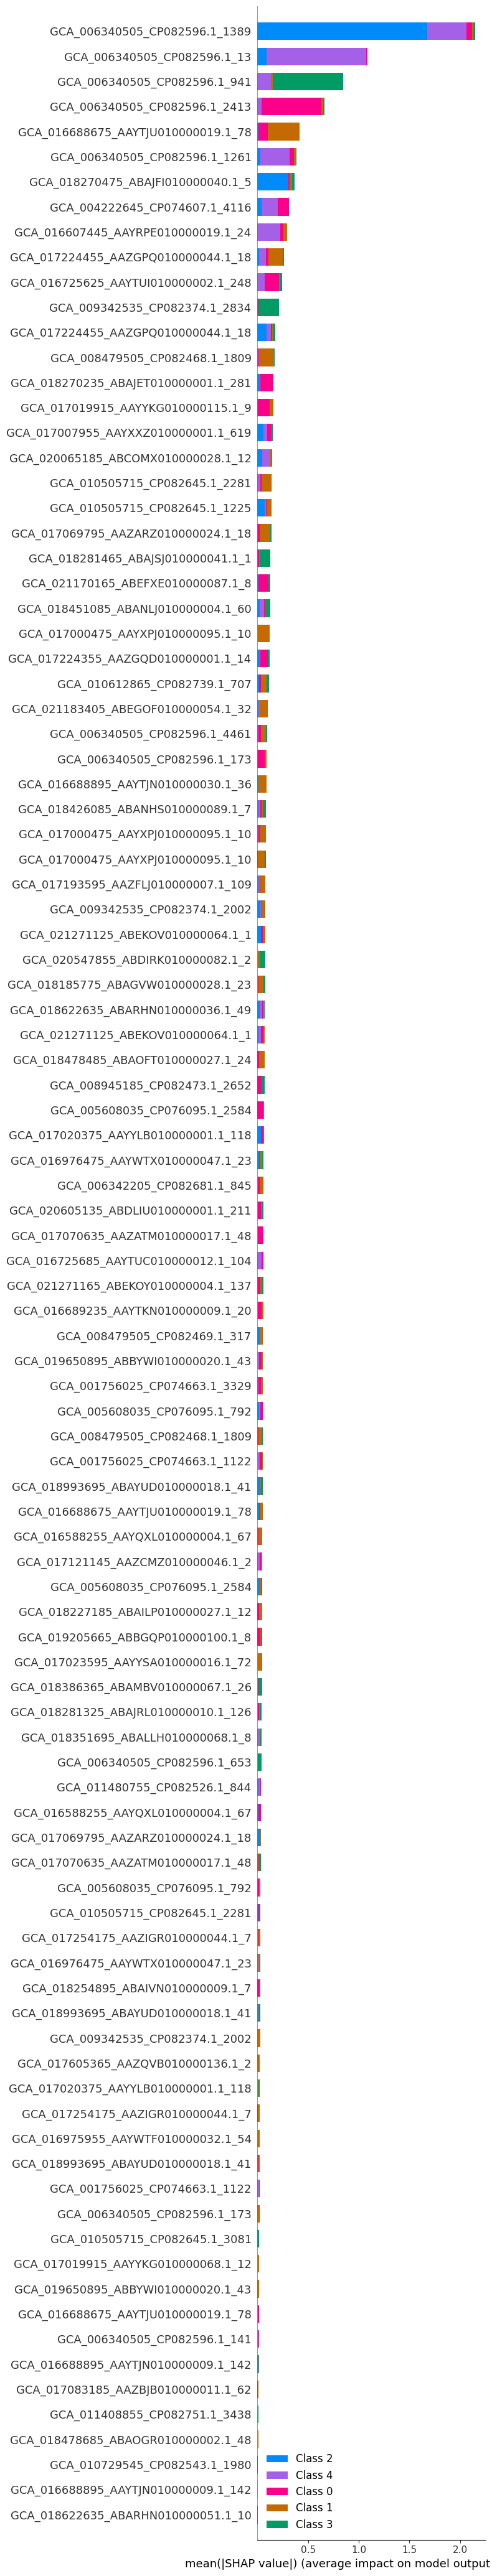

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.835567       0.845638
1   DecisionTreeEntropy      none        0.827183       0.805369
2          RandomForest      none        0.904396       0.906040
3               XGBoost      none        0.964756       0.926174
4              lightGBM      none        0.991611       0.932886
5                   MLP      none        0.901037       0.892617
6                   cnn      none        0.689618       0.906040
7      DecisionTreeGini       pca        0.771839       0.711409
8   DecisionTreeEntropy       pca        0.812116       0.771812
9          RandomForest       pca        0.877527       0.885906
10              XGBoost       pca        0.867477       0.892617
11             lightGBM       pca        0.996644       0.879195
12                  MLP       pca        0.885903       0.885906
13                  cnn       pca        0.788530       0.865772

In [14]:
# Run 11/17 -- Salmonella Data

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "/projects/leaph/sandeep/ncbi_dataset/dataset_PresenceAbsence.csv"
feature_names_path = "/projects/leaph/sandeep/ncbi_dataset/feature_names_PresenceAbsence.csv"
feature_names = pd.read_csv(feature_names_path, header=None)[0].tolist()

selections = ['none','pca'] # Default Feature Selection Metrics
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {'Bovine': 0, 'Environmental': 1, 'Poultry': 2, 'Swine': 3, 'Wild bird': 4}

resultsSalmonella = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
resultsSalmonella

In [23]:
# Compare PCA to None
results = resultsSalmonella

# Create a new DataFrame to store the results
result_comparison = []

# Get unique models from the original DataFrame
unique_models = results['Model'].unique()

# Calculate and store the percentage increase for each model
for model in unique_models:
    model_data = results[results['Model'] == model]
    
    # Extract accuracy values for 'pca' and 'none' selections
    pca_train_accuracy = model_data[model_data['Selection'] == 'pca']['Train_Accuracy'].values[0]
    none_train_accuracy = model_data[model_data['Selection'] == 'none']['Train_Accuracy'].values[0]
    pca_test_accuracy = model_data[model_data['Selection'] == 'pca']['Test_Accuracy'].values[0]
    none_test_accuracy = model_data[model_data['Selection'] == 'none']['Test_Accuracy'].values[0]
    train_increase_percentage = ((pca_train_accuracy - none_train_accuracy) / none_train_accuracy) * 100
    test_increase_percentage = ((pca_test_accuracy - none_test_accuracy) / none_test_accuracy) * 100
    result = {'Model': model,'Train_Accuracy_Increase%': train_increase_percentage,'Test_Accuracy_Increase%': test_increase_percentage}
    result_comparison.append(result)

In [22]:
pd.DataFrame(result_comparison)

Model  Train_Accuracy_Increase%  Test_Accuracy_Increase%
0     DecisionTreeGini                 -7.626887               -15.873016
1  DecisionTreeEntropy                 -1.821473                -4.166667
2         RandomForest                 -2.970862                -2.222222
3              XGBoost                -10.083304                -3.623188
4             lightGBM                  0.507614                -5.755396
5                  MLP                 -1.679686                -0.751880
6                  cnn                 14.343019                -4.444441

In [26]:
from scipy.stats import ttest_rel

pca_train = results[results['Selection'] == 'pca']['Train_Accuracy']
none_train = results[results['Selection'] == 'none']['Train_Accuracy']
pca_test = results[results['Selection'] == 'pca']['Test_Accuracy']
none_test = results[results['Selection'] == 'none']['Test_Accuracy']

t_stat, p_value = ttest_rel(pca_train, none_train)
t_stat_test, p_value_test = ttest_rel(pca_test, none_test)

print("Paired t-test for Train Accuracy:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

print("Paired t-test for Test Accuracy:")
print(f"T-statistic: {t_stat_test}")
print(f"P-value: {p_value_test}")

Paired t-test for Train Accuracy:
T-statistic: -0.7020887310395456
P-value: 0.5089296053079433
Paired t-test for Train Accuracy:
T-statistic: -2.9247996927605393
P-value: 0.02646548126601354


In [31]:
gene_to_remove = ['GCA_006340505_CP082596.1_1389', 'GCA_006340505_CP082596.1_1261', 'GCA_018426085_ABANHS010000089.1_7', 'GCA_010612865_CP082739.1_707', 'GCA_006340505_CP082596.1_269', 'GCA_006340505_CP082596.1_941', 'GCA_006340505_CP082596.1_2413', 'GCA_019842405_ABCGAA010000119.1_16', 'GCA_016588255_AAYQXL010000004.1_67', 'GCA_018451085_ABANLJ010000004.1_60', 'GCA_018281325_ABAJRL010000010.1_126', 'GCA_017019915_AAYYKG010000068.1_12', 'GCA_021183405_ABEGOF010000054.1_32', 'GCA_016588255_AAYQXL010000028.1_27', 'GCA_018270235_ABAJET010000001.1_281', 'GCA_008479505_CP082468.1_1809', 'GCA_016725625_AAYTUI010000008.1_59', 'GCA_016607445_AAYRPE010000019.1_24', 'GCA_001756025_CP074663.1_3393', 'GCA_001756025_CP074663.1_3329', 'GCA_017020375_AAYYLB010000001.1_118', 'GCA_017007955_AAYXXZ010000001.1_619', 'GCA_016493065_AAYMKG010000067.1_5', 'GCA_006340505_CP082596.1_4461', 'GCA_010729545_CP082543.1_1980', 'GCA_021271125_ABEKOV010000064.1_1', 'GCA_021271125_ABEKOV010000064.1_1', 'GCA_010505715_CP082645.1_1225', 'GCA_020605135_ABDLIU010000001.1_211', 'GCA_016725625_AAYTUI010000002.1_248', 'GCA_017224455_AAZGPQ010000044.1_18', 'GCA_017224455_AAZGPQ010000044.1_18', 'GCA_017224355_AAZGQD010000001.1_14', 'GCA_017605365_AAZQVB010000136.1_2', 'GCA_018478485_ABAOFT010000027.1_24', 'GCA_018270475_ABAJFI010000040.1_5', 'GCA_008945185_CP082473.1_2652', 'GCA_018622635_ABARHN010000036.1_49', 'GCA_008479505_CP082469.1_317', 'GCA_018478685_ABAOGR010000002.1_48', 'GCA_004222645_CP074607.1_4116', 'GCA_006340505_CP082596.1_173', 'GCA_001756025_CP074663.1_3201', 'GCA_017069795_AAZARZ010000024.1_18', 'GCA_006340505_CP082596.1_173', 'GCA_006342205_CP082681.1_589', 'GCA_018254895_ABAIVN010000009.1_7', 'GCA_010505715_CP082645.1_2281', 'GCA_010505715_CP082645.1_2281', 'GCA_009342535_CP082374.1_2834', 'GCA_017019915_AAYYKG010000115.1_9', 'GCA_016689235_AAYTKN010000009.1_20', 'GCA_018622635_ABARHN010000051.1_10', 'GCA_001756025_CP074663.1_1122', 'GCA_017019915_AAYYKG010000115.1_9', 'GCA_006340505_CP082596.1_1005', 'GCA_020065185_ABCOMX010000028.1_12', 'GCA_001756025_CP074663.1_1122', 'GCA_016688675_AAYTJU010000019.1_78', 'GCA_006340505_CP082596.1_141', 'GCA_018185775_ABAGVW010000028.1_23', 'GCA_018227185_ABAILP010000027.1_12', 'GCA_017000475_AAYXPJ010000095.1_10', 'GCA_016688895_AAYTJN010000009.1_142', 'GCA_017000475_AAYXPJ010000095.1_10', 'GCA_018993695_ABAYUD010000018.1_41', 'GCA_018993695_ABAYUD010000018.1_41', 'GCA_017000475_AAYXPJ010000095.1_10', 'GCA_019650895_ABBYWI010000020.1_43', 'GCA_011480755_CP082526.1_428', 'GCA_019650895_ABBYWI010000020.1_43', 'GCA_010505715_CP082645.1_3081', 'GCA_016975955_AAYWTF010000032.1_54', 'GCA_016688895_AAYTJN010000009.1_142', 'GCA_017083185_AAZBJB010000011.1_62', 'GCA_017083185_AAZBJB010000011.1_62', 'GCA_018993695_ABAYUD010000018.1_41', 'GCA_017023595_AAYYSA010000016.1_72', 'GCA_005608035_CP076095.1_2584', 'GCA_017193595_AAZFLJ010000007.1_109', 'GCA_005608035_CP076095.1_792', 'GCA_018281465_ABAJSJ010000041.1_1', 'GCA_019205665_ABBGQP010000100.1_8', 'GCA_005608035_CP076095.1_792', 'GCA_019208585_ABBGUA010000065.1_4', 'GCA_005608035_CP076095.1_2584', 'GCA_017193595_AAZFLJ010000007.1_109', 'GCA_017193595_AAZFLJ010000007.1_109', 'GCA_017254175_AAZIGR010000044.1_6', 'GCA_016976475_AAYWTX010000047.1_23', 'GCA_017254175_AAZIGR010000044.1_7', 'GCA_016688675_AAYTJU010000019.1_78', 'GCA_009342535_CP082374.1_2002', 'GCA_016976475_AAYWTX010000047.1_23', 'GCA_017070635_AAZATM010000017.1_48', 'GCA_009342535_CP082374.1_2002', 'GCA_016588995_AAYQYS010000006.1_71', 'GCA_006340535_CP082674.1_4436', 'GCA_018228105_ABAINN010000013.1_31', 'GCA_011480755_CP082526.1_1676']

In [29]:
unique_gene_families = set(gene_to_remove)
count_of_gene_families = len(unique_gene_families)

print(f"Number of unique gene families: {count_of_gene_families}")

Number of unique gene families: 80


In [45]:
gene_to_remove = ['GCA_006340505_CP082596.1_1389', 'GCA_016607445_AAYRPE010000019.1_24', 'GCA_016688675_AAYTJU010000019.1_78', 'GCA_004222645_CP074607.1_4116', 'GCA_017224455_AAZGPQ010000044.1_18', 'GCA_006340505_CP082596.1_269', 'GCA_006340505_CP082596.1_941', 'GCA_006340505_CP082596.1_2413', 'GCA_006340505_CP082596.1_1261', 'GCA_018270475_ABAJFI010000040.1_5']

Dummy Gene Distribution dummy_gene
0    676
1     69
Name: count, dtype: int64
 The shape of X is  4315
[[-18.53516592  -2.19354707  -2.30181903 ...  -0.41313564  -0.5512485
   -1.32399215]
 [ 22.75267807  -1.90500469  -2.72784434 ...  -0.41265471  -0.41711785
   -0.4105673 ]
 [ 20.45676781  -2.83351174   0.22214044 ...   2.0657625   -4.39302398
    4.50315377]
 ...
 [-15.62839383  -1.86220762  -1.53911803 ...   0.08727406  -0.99875378
    2.60600181]
 [-16.06746405  -1.21321141  -1.07042153 ...   0.07300131   3.24184029
   -9.4174039 ]
 [ -3.09085916  -0.75884795  -0.60811673 ...  -2.38155834   0.34735719
    0.56330051]]
[-18.53516592  22.75267807  20.45676781 -14.49830823 -18.16704481
 -18.28682504  -6.36818859  27.08354016  -6.34386838 -16.35765646
 -18.12623865  40.77456843  -6.28868948  -6.4331913   22.12782049
 -16.54907551 -15.4473914   21.67168606  -5.84375125  23.81244326
 -15.56470588  22.48756952  -6.40569948  26.26303302  -6.42136223
  -7.40402623 -17.45654989 -19.25944636

[[-18.53516592  -2.19354698  -2.3018187  ...  -1.16195247  -2.63277777
   -2.05921348]
 [ 22.75267807  -1.90500459  -2.72784441 ...   0.30368161  -0.18309755
   -0.03551915]
 [ 20.4567678   -2.83351155   0.22213934 ...  -4.56470313  -1.75781195
    2.6217836 ]
 ...
 [-15.62839384  -1.86220771  -1.53911816 ...   0.57900079   1.50942741
    2.57889881]
 [-16.06746407  -1.21321141  -1.07042159 ...   1.39055106   2.33814537
   -6.77956992]
 [ -3.09085912  -0.75884805  -0.60811684 ...   7.02104126   0.65917704
    5.58879865]]
[-18.53516592  22.75267807  20.4567678  -14.49830824 -18.1670448
 -18.28682504  -6.36818859  27.0835401   -6.34386839 -16.35765645
 -18.12623857  40.77456843  -6.28868947  -6.43319132  22.12782047
 -16.54907552 -15.4473914   21.67168608  -5.84375126  23.81244331
 -15.56470588  22.48756953  -6.40569954  26.26303302  -6.42136223
  -7.40402631 -17.45654989 -19.25944637  26.55620229  -6.36166698
  -4.50207719  25.75947475  25.16738618  -6.81986948 -17.6862343
  -6.2578352

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.780129591623942
Test Accuracy               =  0.8859060406684875
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.9983221476510067
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-18.53516592  -2.19354702  -2.3018186  ...   1.74440335  -1.34886041
    0.35498823]
 [ 22.75267807  -1.9050046   -2.72784438 ...   0.25074432   0.26689018
   -0.58617226]
 [ 20.45676772  -2.83351327   0.22213977 ...   0.39424612   2.87112343
    3.40482083]
 ...
 [-15.62839385  -1.86220779  -1.53911854 ...  -2.88939111   2.23929435
   -0.50076288]
 [-16.06746411  -1.21321058  -1.07042217 ...   7.08006509  -5.31827814
   -2.45570258]
 [ -3.09085916  -0.75884803  -0.60811695 ...   0.39510439  -0.48241074
 

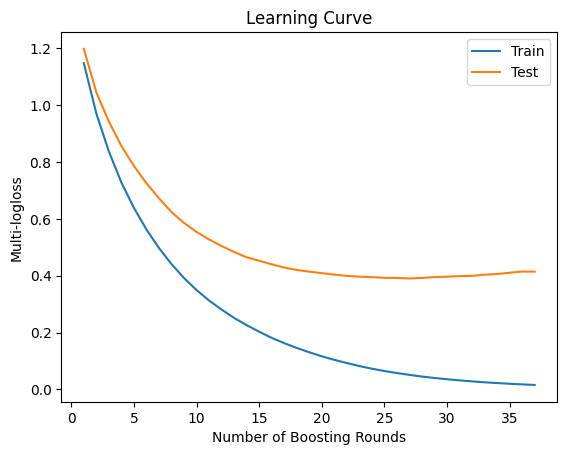

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.9983221476510067
Test Accuracy               =  0.8791946308724832


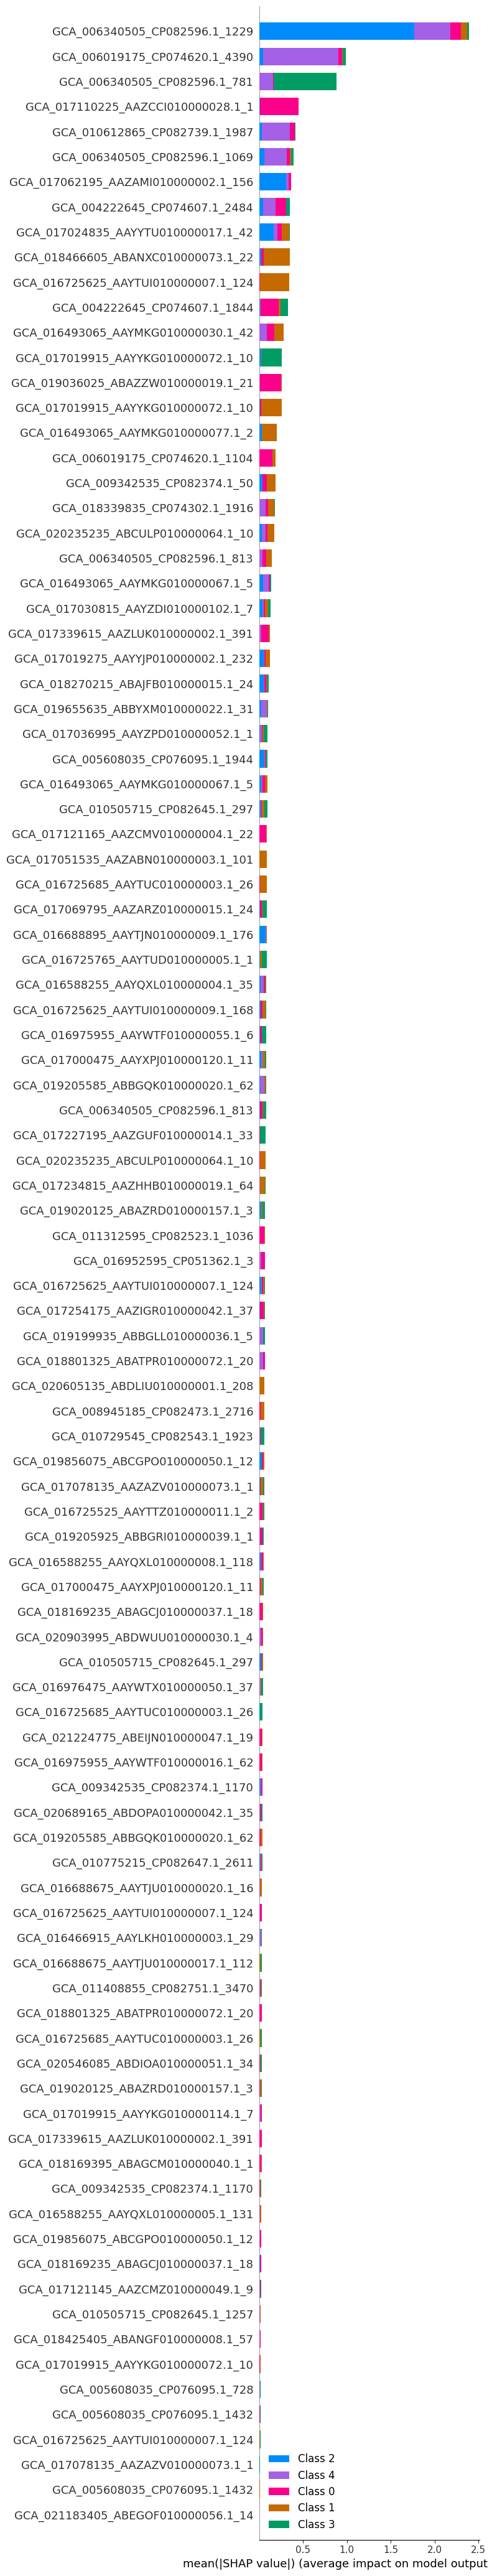

Model Selection  Train_Accuracy  Test_Accuracy
0     DecisionTreeGini       pca        0.775147       0.744966
1  DecisionTreeEntropy       pca        0.783624       0.765101
2         RandomForest       pca        0.872494       0.885906
3              XGBoost       pca        0.875827       0.892617
4             lightGBM       pca        0.998322       0.865772
5                  MLP       pca        0.892637       0.899329
6                  cnn       pca        0.780130       0.885906

In [45]:
# Test - After removing the top 100 important genes from SHAP and PCA

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "/projects/leaph/sandeep/ncbi_dataset/dataset_PresenceAbsence.csv"
feature_names_path = "/projects/leaph/sandeep/ncbi_dataset/feature_names_PresenceAbsence.csv"
feature_names = pd.read_csv(feature_names_path, header=None)[0].tolist()

selections = ['pca'] # Default Feature Selection Metrics
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {'Bovine': 0, 'Environmental': 1, 'Poultry': 2, 'Swine': 3, 'Wild bird': 4}

results_100 = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results_100

In [46]:
# Percentage Increase from PCA to PCA (without top 100 genes)
results_100 = results
results = resultsSalmonella

# Create a new DataFrame to store the results
result_comparison = []

# Get unique models from the original DataFrame
unique_models = results['Model'].unique()

# Calculate and store the percentage increase for each model
for model in unique_models:
    model_data = results[results['Model'] == model]
    model_data_100 = results_100[results_100['Model'] == model]
    
    # Extract accuracy values for 'pca' and 'none' selections
    pca_train_accuracy = model_data[model_data['Selection'] == 'pca']['Train_Accuracy'].values[0]
    pca_train_accuracy_100 = model_data_100[model_data['Selection'] == 'pca']['Train_Accuracy'].values[0]
    pca_test_accuracy = model_data[model_data['Selection'] == 'pca']['Test_Accuracy'].values[0]
    pca_test_accuracy_100 = model_data_100[model_data['Selection'] == 'pca']['Test_Accuracy'].values[0]
    train_increase_percentage = ((pca_train_accuracy - none_train_accuracy) / none_train_accuracy) * 100
    test_increase_percentage = ((pca_test_accuracy - none_test_accuracy) / none_test_accuracy) * 100
    result = {'Model': model,'Train_Accuracy_Increase%': train_increase_percentage,'Test_Accuracy_Increase%': test_increase_percentage}
    result_comparison.append(result)

pd.DataFrame(result_comparison)

Model  Train_Accuracy_Increase%  Test_Accuracy_Increase%
0     DecisionTreeGini                 11.922662               -21.481480
1  DecisionTreeEntropy                 17.763162               -14.814813
2         RandomForest                 27.248299                -2.222220
3              XGBoost                 25.790935                -1.481480
4             lightGBM                 44.521181                -2.962961
5                  MLP                 28.462770                -2.222220
6                  cnn                 14.343019                -4.444441

In [47]:
pca_train = results[results['Selection'] == 'pca']['Train_Accuracy']
pca_train_100 = results_100[results_100['Selection'] == 'pca']['Train_Accuracy']
pca_test = results[results['Selection'] == 'pca']['Test_Accuracy']
pca_test_100 = results_100[results_100['Selection'] == 'pca']['Test_Accuracy']

t_stat, p_value = ttest_rel(pca_train, pca_train_100)
t_stat_test, p_value_test = ttest_rel(pca_test, pca_test_100)

print("Paired t-test for Train Accuracy:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

print("Paired t-test for Test Accuracy:")
print(f"T-statistic: {t_stat_test}")
print(f"P-value: {p_value_test}")

Paired t-test for Train Accuracy:
T-statistic: nan
P-value: nan
Paired t-test for Test Accuracy:
T-statistic: nan
P-value: nan


 The shape of X is  4314
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.8154323807590139
Test Accuracy               =  0.8523489932885906
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.810263438404142
Test Accuracy               =  0.7516778523489933
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.8943031656599496
Test Accuracy               =  0.8926174496644296
***********************************************************************************
Model                       =  XGBoost
Feature Selection Criteria  =  none
Train Accuracy

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.7632945775985718
Test Accuracy               =  0.8859060406684875
[[-18.53932617  -2.19281116  -2.29886355 ...  -2.46914862  -1.32061653
    1.16375309]
 [ 22.75068848  -1.9049419   -2.72762601 ...   0.17038431  -0.39432314
   -0.87194277]
 [ 20.45470911  -2.83344333   0.22252141 ...   4.06806742   0.57790521
    3.42457493]
 ...
 [-15.63152563  -1.86176892  -1.53757445 ...   2.27001537   2.07663513
   -1.84889816]
 [-16.07014584  -1.2128756   -1.06934989 ...   0.42439426  -7.04865242
   -0.1917814 ]
 [ -3.09269346  -0.75875075  -0.60797925 ...  -0.12008536   2.02202048
    2.64553709]]
[-18.53932617  22.75068848  20.45470911 -14.50126247 -18.16963245
 -18.2894242   -6.37045346  27.08191202  -6.3461588  -16.35978828
 -18.12900105  40.77249268  -6.29093948  -6.43548872  22.12609497
 -16.55189134 -15.4

[[-18.53932617  -2.19281132  -2.29886399 ...   2.67161457  -2.3328229
    0.24524428]
 [ 22.75068848  -1.90494165  -2.72762588 ...  -0.76927893  -0.46565069
    0.62591371]
 [ 20.45470914  -2.83344255   0.22252419 ...   0.7128849    1.6944829
   -6.04715661]
 ...
 [-15.63152563  -1.86176857  -1.53757345 ...  -3.25959073   1.97324059
   -2.17680513]
 [-16.07014587  -1.21287516  -1.06935007 ...  -5.32910809  -0.38546626
    6.84250285]
 [ -3.09269345  -0.75875082  -0.6079805  ...  -2.64658476   1.41527299
    0.47790291]]
[-18.53932617  22.75068848  20.45470914 -14.50126245 -18.16963245
 -18.28942419  -6.37045346  27.08191203  -6.34615879 -16.35978827
 -18.12900103  40.77249269  -6.29093949  -6.4354887   22.12609496
 -16.55189135 -15.4514247   21.66997496  -5.84581199  23.81082326
 -15.56782971  22.48535076  -6.38000867  26.26145824  -6.42362056
  -7.37962987 -17.46098964 -19.26373985  26.55418611  -6.36392444
  -4.47853375  25.75725335  25.16574562  -6.82215957 -17.68945354
  -6.2601021

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.8254149357477824
Test Accuracy               =  0.8657718300819397
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.9949664429530202
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-18.53932615  -2.19281148  -2.298864   ...   1.03217308  -2.54867954
   -0.80828117]
 [ 22.75068847  -1.9049419   -2.72762595 ...  -0.22938097  -0.13534539
   -0.1062665 ]
 [ 20.45470916  -2.83344306   0.22251975 ...   4.17385571  -5.27331679
   -2.37903988]
 ...
 [-15.63152564  -1.8617685   -1.53757413 ...  -1.17547278   1.6890878
    0.17650749]
 [-16.07014588  -1.21287501  -1.06935151 ...  -3.28342677   0.42198313
    3.48158572]
 [ -3.09269343  -0.75875068  -0.60798015 ...   0.69007479   6.40510366
 

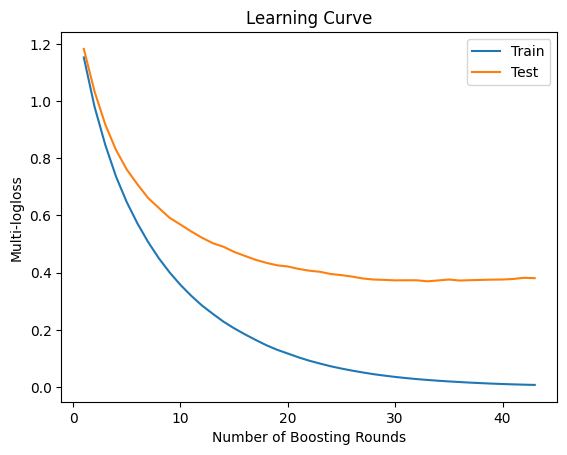

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  1.0
Test Accuracy               =  0.8791946308724832
Gene Families of most importance: ['GCA_006340505_CP082596.1_1229', 'GCA_006340505_CP082596.1_1069', 'GCA_019655635_ABBYXM010000022.1_31', 'GCA_009342535_CP082374.1_50', 'GCA_006019175_CP074620.1_4390', 'GCA_006340505_CP082596.1_781', 'GCA_004222645_CP074607.1_1844', 'GCA_017110225_AAZCCI010000028.1_1', 'GCA_016493065_AAYMKG010000067.1_5', 'GCA_017030815_AAYZDI010000102.1_7', 'GCA_017234815_AAZHHB010000019.1_64', 'GCA_016725625_AAYTUI010000013.1_12', 'GCA_017254175_AAZIGR010000044.1_42', 'GCA_016493065_AAYMKG010000067.1_5', 'GCA_019036025_ABAZZW010000019.1_21', 'GCA_016588255_AAYQXL010000005.1_131', 'GCA_020605135_ABDLIU010000001.1_208', 'GCA_010612865_CP082739.1_1987', 'GCA_017000475_AAYXPJ010000120.1_11', 'GCA_005608035_CP076095.1_1944', 'GCA_0

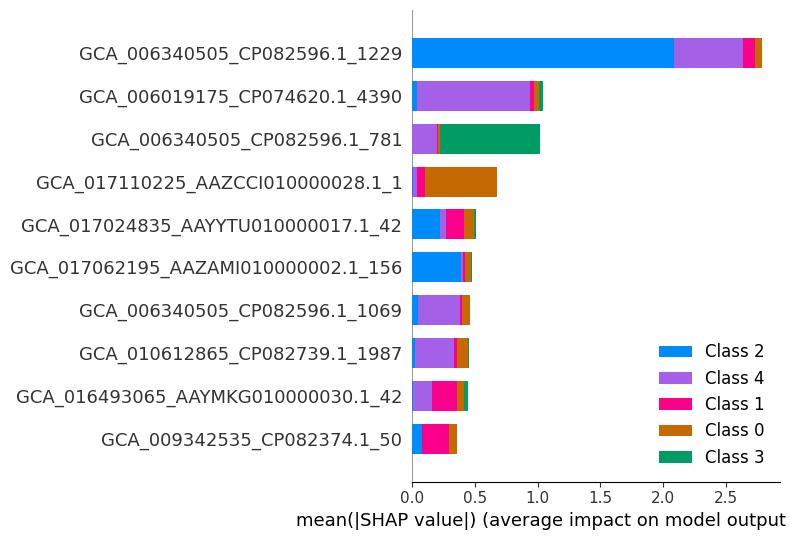

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.815432       0.852349
1   DecisionTreeEntropy      none        0.810263       0.751678
2          RandomForest      none        0.894303       0.892617
3               XGBoost      none        0.902704       0.912752
4              lightGBM      none        0.981544       0.919463
5                   MLP      none        0.892654       0.899329
6                   cnn      none        0.763295       0.885906
7      DecisionTreeGini       pca        0.768480       0.738255
8   DecisionTreeEntropy       pca        0.808775       0.758389
9          RandomForest       pca        0.875844       0.879195
10              XGBoost       pca        0.887586       0.885906
11             lightGBM       pca        0.994966       0.865772
12                  MLP       pca        0.880903       0.865772
13                  cnn       pca        0.825415       0.865772

In [51]:
# Test - After removing all the 10 "important" genes from the PCA components

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "/projects/leaph/sandeep/ncbi_dataset/dataset_PresenceAbsence.csv"
feature_names_path = "/projects/leaph/sandeep/ncbi_dataset/feature_names_PresenceAbsence.csv"
feature_names = pd.read_csv(feature_names_path, header=None)[0].tolist()

selections = ['none','pca'] # Default Feature Selection Metrics
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {'Bovine': 0, 'Environmental': 1, 'Poultry': 2, 'Swine': 3, 'Wild bird': 4}

results = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results

In [42]:
pca_test

7     0.711409
8     0.771812
9     0.885906
10    0.892617
11    0.879195
12    0.885906
13    0.865772
Name: Test_Accuracy, dtype: float64

#### b. Ralstonia

Dummy Gene Distribution dummy_gene
0    196
Name: count, dtype: int64
 The shape of X is  2268
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  none
Train Accuracy              =  0.4294871794871795
Test Accuracy               =  0.425
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  none
Train Accuracy              =  0.4166666666666667
Test Accuracy               =  0.375
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  none
Train Accuracy              =  0.48717948717948717
Test Accuracy               =  0.55
***********************************************************************************
Model                       =  SVM
Feature Selection Crit

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  none
Train Accuracy              =  0.4294871787230174
Test Accuracy               =  0.4749999940395355
[[-1.47453268e+00 -1.17497099e+00 -7.93538134e-01 ... -1.44563238e-02
  -1.41226980e-02 -2.63013941e-02]
 [-1.44827120e+00 -1.14839594e+00 -8.13542155e-01 ... -1.82627029e-02
  -2.08217099e-02  1.25159777e-03]
 [-1.32842313e+00 -4.81976806e-01 -4.23523831e-01 ...  2.53233646e-02
  -9.93261332e-02 -7.84160379e-02]
 ...
 [-1.39863098e+00 -1.09060337e+00 -8.01786930e-01 ...  1.04330052e-01
  -2.57703897e-02 -1.90275160e-02]
 [-1.26126451e+00 -8.53481369e-01 -5.99313154e-01 ...  3.77287875e-01
  -3.50538720e-01 -3.76570410e-01]
 [-7.62316082e-01 -1.04404998e+00 -6.47180206e-01 ... -1.34771759e-02
   3.36208143e-02 -8.47628164e-02]]
[ -1.47453268  -1.4482712   -1.32842313  -1.3649717   -1.31097967
  -1.42946231  -1.42954955  -1.43062736  -1

[[-1.47453268e+00 -1.17497099e+00 -7.93538134e-01 ...  1.52495950e-02
  -9.70657800e-03 -1.71612578e-02]
 [-1.44827120e+00 -1.14839594e+00 -8.13542155e-01 ...  1.32625308e-02
  -1.74321369e-02  1.39585904e-03]
 [-1.32842313e+00 -4.81976806e-01 -4.23523831e-01 ... -5.67353858e-02
  -1.08578276e-01 -6.40445581e-02]
 ...
 [-1.39863098e+00 -1.09060337e+00 -8.01786930e-01 ... -1.14558332e-01
  -3.50001777e-02 -1.68545022e-02]
 [-1.26126451e+00 -8.53481369e-01 -5.99313154e-01 ... -3.47382775e-01
  -3.18745458e-01 -3.11098342e-01]
 [-7.62316082e-01 -1.04404998e+00 -6.47180206e-01 ...  9.61194319e-03
   3.07117880e-02 -8.42641219e-02]]
[ -1.47453268  -1.4482712   -1.32842313  -1.3649717   -1.31097967
  -1.42946231  -1.42954955  -1.43062736  -1.41026531  -1.16646791
  -1.30708839  -1.10738569  -1.29745775  -1.41026531  -1.43073398
  -1.43171459  -1.24160464  -1.4309958   -1.46821411  -1.49813507
  -1.42971759  -1.28879198  -1.43079437  -1.26974989  -1.06355505
  -1.33863278  -0.92289743  -1.356

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.4423076907793681
Test Accuracy               =  0.550000011920929
***********************************************************************************
Completed Training All models
The Best Accuracy:  0.9935897435897436
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[-1.47453268 -1.17497099 -0.79353813 ...  0.01717575 -0.0022127
   0.00233119]
 [-1.4482712  -1.14839594 -0.81354216 ...  0.01494855 -0.02066949
   0.00909484]
 [-1.32842313 -0.48197681 -0.42352383 ... -0.02337944 -0.1012434
  -0.05178594]
 ...
 [-1.39863098 -1.09060337 -0.80178693 ... -0.09957984 -0.03748245
  -0.04622328]
 [-1.26126451 -0.85348137 -0.59931315 ... -0.22834024 -0.19543848
  -0.24848118]
 [-0.76231608 -1.04404998 -0.64718021 ...  0.01453032  0.03243842
  -0.08670651]]
[ -1.47453268  -1.4482

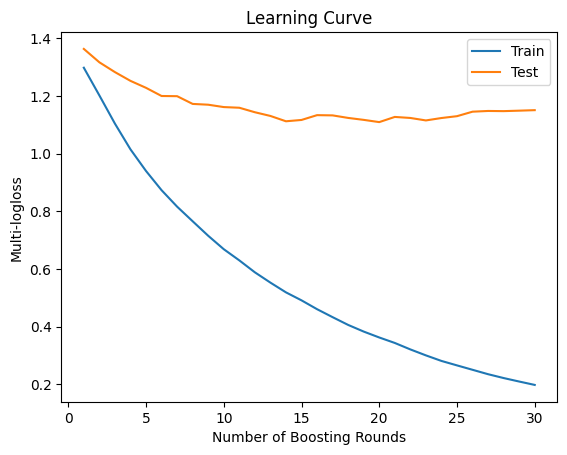

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.9038461538461539
Test Accuracy               =  0.525


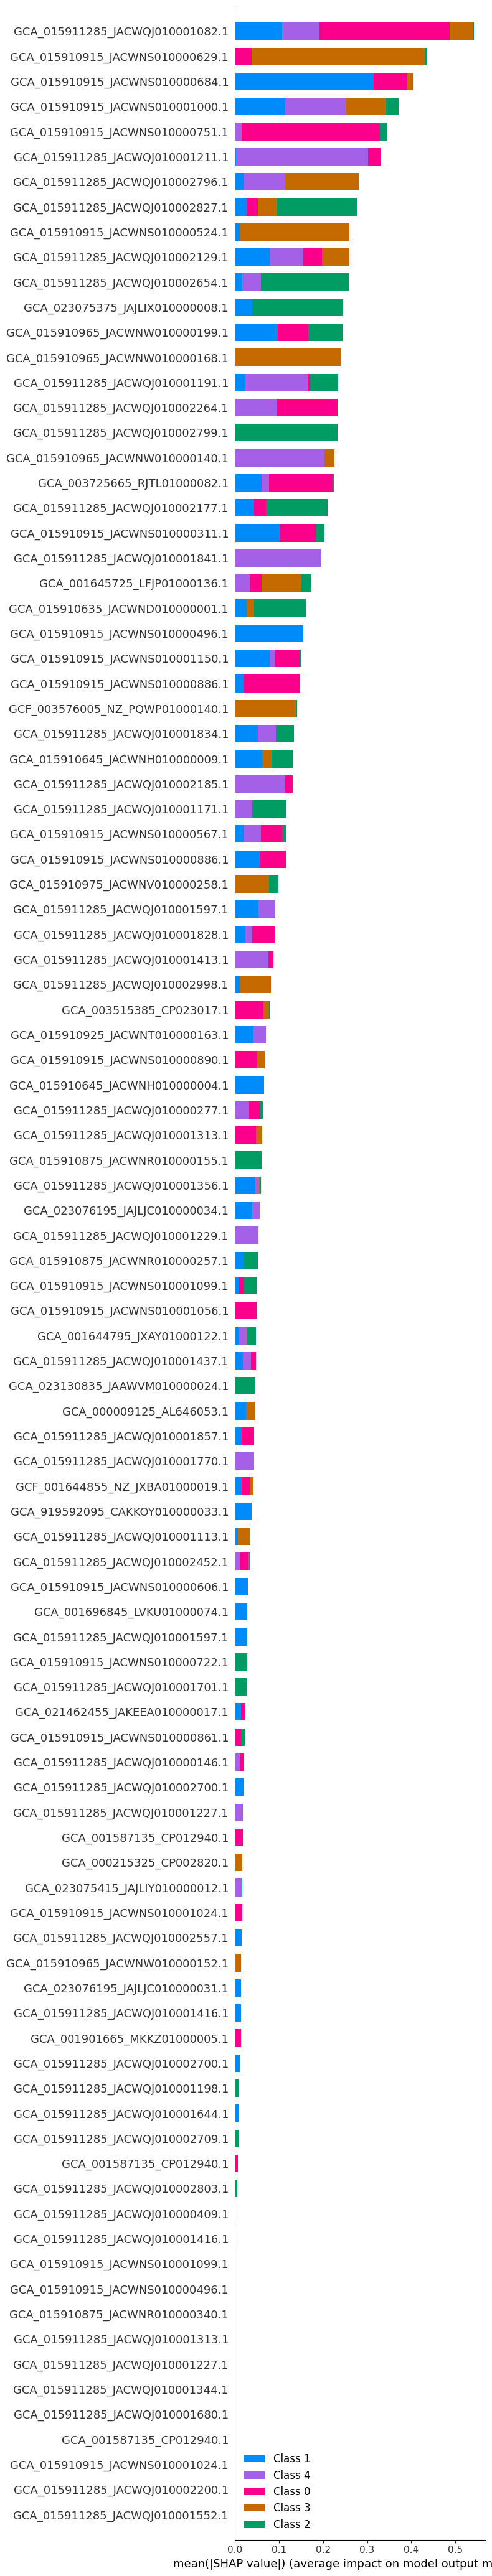

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini      none        0.429487          0.425
1   DecisionTreeEntropy      none        0.416667          0.375
2          RandomForest      none        0.487179          0.550
3                   SVM      none        0.519231          0.450
4               XGBoost      none        0.467949          0.425
5              lightGBM      none        0.455128          0.425
6                   MLP      none        0.461538          0.525
7                   cnn      none        0.429487          0.475
8      DecisionTreeGini       pca        0.467949          0.475
9   DecisionTreeEntropy       pca        0.429487          0.525
10         RandomForest       pca        0.525641          0.625
11                  SVM       pca        0.448718          0.525
12              XGBoost       pca        0.500000          0.525
13             lightGBM       pca        0.993590          0.575
14                  MLP       pca        0.403846          0.550
15                  cnn       pca        0.442308          0.550

In [50]:
# Run 11/03/23
# Top 10 Sources

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "dataset/dataset_pa_top5.csv"
feature_names_path = "dataset/dataset_pa_top5.csv"
feature_names = pd.read_csv(feature_names_path).columns.tolist()
# Drop 'Unnamed: 0' from the feature_names
if 'Unnamed: 0' in feature_names:
    feature_names.remove('Unnamed: 0')

selections = ['none','pca'] # Default Feature Selection Metrics 
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

resultsRalstonia = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
resultsRalstonia

### MCA (Multiple Correspondence Analysis)

In [16]:
from prince import MCA

 # Import Dataset as DataFrame
dataset_path = "dataset/dataset.csv"
df = pd.read_csv(dataset_path, index_col=0)
mca = MCA(n_components=100)  # You can adjust the number of components as needed
mca.fit(df)

mca_results = mca.transform(df)

In [17]:
mca_results

0         1         2         3         4         5    
GCA_016465575 -0.031197 -0.017334  0.084364 -0.023708 -0.077398 -0.061071  \
GCA_016725705 -0.030890 -0.019347  0.016187 -0.014871  0.015073  0.187004   
GCA_021146745 -0.031058  0.012187  0.011263 -0.009911  0.026657  0.020184   
GCA_019111145 -0.031207 -0.017725  0.086468 -0.024348 -0.080060 -0.063646   
GCA_019650895 -0.031095  0.015614  0.015017 -0.013613  0.041920  0.038364   
...                 ...       ...       ...       ...       ...       ...   
GCA_018228085 -0.031444  0.310814 -0.208494  0.081189 -0.145556  0.010601   
GCA_018386365 -0.030997 -0.011390  0.013861 -0.010294  0.006800  0.034914   
GCA_021147305 -0.031058  0.012187  0.011263 -0.009911  0.026657  0.020184   
GCA_018125445 -0.031212 -0.017940  0.087652 -0.024711 -0.081656 -0.065281   
GCA_018280345 -0.031388 -0.223060 -0.222670  0.061805 -0.009581 -0.037010   

                     6         7         8         9   ...        90   
GCA_016465575  0.006538  0.030685 -0.006057  0.004467  ... -0.000463  \
GCA_016725705 -0.027613  0.135631 -0.015241  0.009923  ... -0.000141   
GCA_021146745 -0.002767 -0.028541  0.039854 -0.021984  ... -0.000728   
GCA_019111145  0.006823  0.032158 -0.006376  0.004710  ... -0.002049   
GCA_019650895 -0.005486 -0.066153  0.115914 -0.069396  ...  0.002300   
...                 ...       ...       ...       ...  ...       ...   
GCA_018228085 -0.000639  0.002090 -0.005041  0.002723  ... -0.001476   
GCA_018386365 -0.003988 -0.013832  0.005755 -0.005120  ... -0.002107   
GCA_021147305 -0.002767 -0.028541  0.039854 -0.021984  ... -0.000728   
GCA_018125445  0.007005  0.033131 -0.006590  0.004874  ... -0.001391   
GCA_018280345 -0.017459  0.006452 -0.001824  0.001885  ...  0.000460   

                     91        92        93        94        95        96   
GCA_016465575 -0.000009  0.000213  0.001629  0.000499  0.000882 -0.001520  \
GCA_016725705 -0.000032  0.000494  0.000158  0.000037  0.000270 -0.000523   
GCA_021146745  0.000707 -0.000504 -0.000563 -0.000521  0.000044 -0.000078   
GCA_019111145 -0.000969  0.001198  0.005042  0.003813 -0.000167 -0.005811   
GCA_019650895  0.003700  0.003629  0.000397 -0.002997 -0.000030 -0.001811   
...                 ...       ...       ...       ...       ...       ...   
GCA_018228085  0.001271 -0.002507 -0.001758 -0.002801  0.001771  0.001099   
GCA_018386365 -0.013792  0.014588 -0.004474 -0.021122  0.006684 -0.012090   
GCA_021147305  0.000707 -0.000504 -0.000563 -0.000521  0.000044 -0.000078   
GCA_018125445 -0.007904  0.007434  0.022793  0.005543  0.006484 -0.011265   
GCA_018280345  0.000766 -0.003274 -0.001650 -0.002984  0.004882 -0.011872   

                     97        98        99  
GCA_016465575 -0.000770  0.000296 -0.000380  
GCA_016725705  0.000081  0.000148 -0.000003  
GCA_021146745  0.000249 -0.000182 -0.000251  
GCA_019111145 -0.003816  0.003760  0.000277  
GCA_019650895  0.003836  0.000785  0.003075  
...                 ...       ...       ...  
GCA_018228085  0.000175 -0.001335  0.000946  
GCA_018386365  0.002753 -0.004914  0.001843  
GCA_021147305  0.000249 -0.000182 -0.000251  
GCA_018125445  0.000626  0.009429 -0.004141  
GCA_018280345  0.005406  0.000978 -0.013835  

[745 rows x 100 columns]

 The shape of X is  4353
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  mca
Train Accuracy              =  0.753396612693095
Test Accuracy               =  0.738255033557047
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  mca
Train Accuracy              =  0.7836150449215776
Test Accuracy               =  0.785234899328859
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  mca
Train Accuracy              =  0.8808943708441196
Test Accuracy               =  0.87248322147651
***********************************************************************************
Model                       =  XGBoost
Feature Selection Criteria  =  mca
Train Accuracy        

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  mca
Train Accuracy              =  0.4244200785954793
Test Accuracy               =  0.8657718300819397
***********************************************************************************
Completed Training All models
The Best Accuracy:  1.0
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  mca
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.360837	valid_1's multi_logloss: 0.564453
[20]	training's multi_logloss: 0.117193	valid_1's multi_logloss: 0.425546
[30]	training's multi_logloss: 0.0371028	valid_1's multi_logloss: 0.395954
[40]	training's multi_logloss: 0.0114616	valid_1's multi_logloss: 0.401023
Early stopping, best iteration is:
[34]	training's multi_logloss: 0.0229881	valid_1's multi_logloss: 0.385076


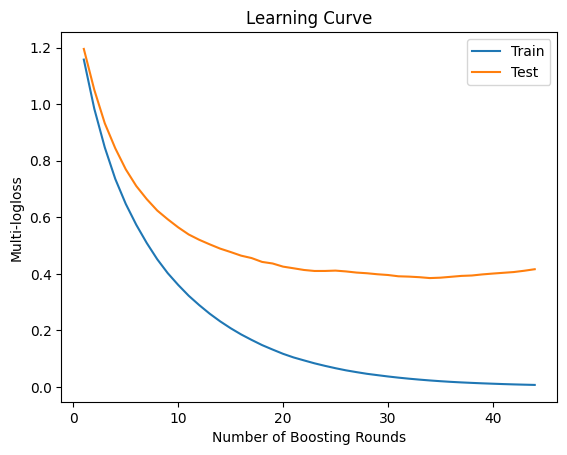

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  mca
Train Accuracy              =  1.0
Test Accuracy               =  0.8791946308724832
Gene Families of most importance: ['GCA_017100675_AAZBNK010000028.1_46_1', 'GCA_017019915_AAYYKG010000111.1_4_1', 'GCA_021224775_ABEIJN010000041.1_15_1', 'GCA_020605355_ABDLJC010000012.1_31_1', 'GCA_006340505_CP082596.1_365_0', 'GCA_017000475_AAYXPJ010000101.1_19_1', 'GCA_010775215_CP082649.1_59_1', 'GCA_018466445_ABANWQ010000016.1_21_1', 'GCA_020979405_ABEAJG010000005.1_153_1', 'GCA_021271165_ABEKOY010000006.1_108_1', 'GCA_017254175_AAZIGR010000044.1_23_1', 'GCA_019856075_ABCGPO010000050.1_12_1', 'GCA_017083165_AAZBIJ010000024.1_13_1', 'GCA_020979405_ABEAJG010000005.1_153_1', 'GCA_020065185_ABCOMX010000028.1_40_1', 'GCA_016975955_AAYWTF010000016.1_75_1', 'GCA_021140105_ABEFCU010000005.1_85_1', 'GCA_020547855_ABDIRK010000082.1_2_1', 'GCA_01760536

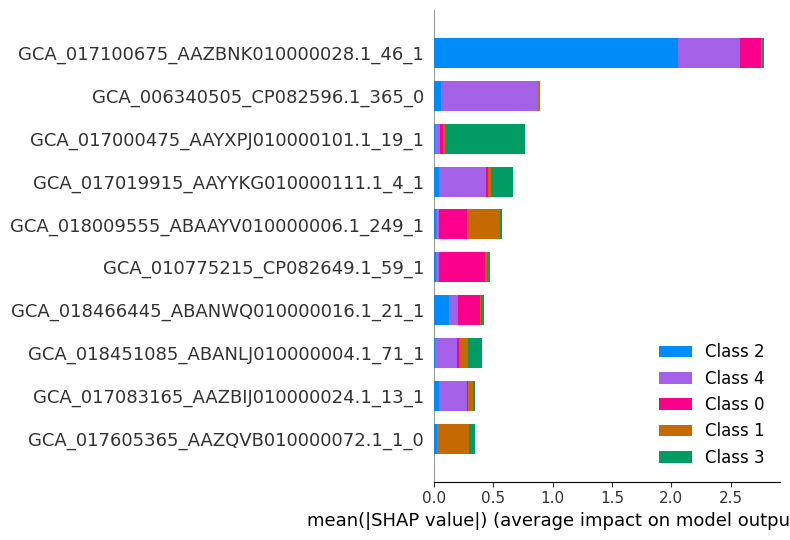

Model Selection  Train_Accuracy  Test_Accuracy
0     DecisionTreeGini       mca        0.753397       0.738255
1  DecisionTreeEntropy       mca        0.783615       0.785235
2         RandomForest       mca        0.880894       0.872483
3              XGBoost       mca        0.890936       0.879195
4             lightGBM       mca        1.000000       0.872483
5                  MLP       mca        0.870802       0.859060
6                  cnn       mca        0.424420       0.865772

In [68]:
# Run 11/17 -- Salmonella Data

import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "dataset/dataset_PresenceAbsence.csv"
feature_names_path = "dataset/feature_names_PresenceAbsence.csv"
feature_names = pd.read_csv(feature_names_path, header=None)[0].tolist()

selections = ['mca'] # Default Feature Selection Metrics 'none','pca',
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {'Bovine': 0, 'Environmental': 1, 'Poultry': 2, 'Swine': 3, 'Wild bird': 4}

results = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results

In [59]:
# Import Dataset as DataFrame
df = pd.read_csv(dataset_path, index_col=0)

# Encode Targets with Integers
df = df.replace(target_encoding)

# Drop columns with only one unique value
df = df.loc[:, df.nunique() > 1]

# Split the Dataset
X = df.drop('target', axis=1)
y = df['target']

# Perform MCA on X
mca = MCA(n_components=100)
mca.fit(X)
X_mca = mca.transform(X)

column_contributions = mca.column_contributions_
column_contributions

0             1     
GCA_006019175_CP074621.1_49_0         8.766288e-04  3.551373e-06  \
GCA_006019175_CP074621.1_49_1         9.840220e-04  3.986441e-06   
GCA_006019175_CP074621.1_81_0         8.908753e-04  3.549881e-06   
GCA_006019175_CP074621.1_81_1         9.682343e-04  3.858134e-06   
GCA_006340505_CP082596.1_365_0        6.622995e-06  3.292520e-07   
...                                            ...           ...   
GCA_016725345_AAYTTQ010000048.1_5_1   1.891216e-06  1.983296e-07   
GCA_018451085_ABANLJ010000004.1_71_0  3.450022e-09  5.172825e-11   
GCA_018451085_ABANLJ010000004.1_71_1  2.566817e-06  3.848582e-08   
GCA_019856075_ABCGPO010000050.1_29_0  1.104138e-09  1.038923e-07   
GCA_019856075_ABCGPO010000050.1_29_1  8.214789e-07  7.729589e-05   

                                               2             3     
GCA_006019175_CP074621.1_49_0         4.244125e-05  3.710240e-05  \
GCA_006019175_CP074621.1_49_1         4.764061e-05  4.164771e-05   
GCA_006019175_CP074621.1_81_0         3.885473e-05  3.520214e-05   
GCA_006019175_CP074621.1_81_1         4.222867e-05  3.825891e-05   
GCA_006340505_CP082596.1_365_0        5.110771e-06  3.905183e-04   
...                                            ...           ...   
GCA_016725345_AAYTTQ010000048.1_5_1   5.995220e-07  7.998667e-08   
GCA_018451085_ABANLJ010000004.1_71_0  4.259564e-10  4.763311e-10   
GCA_018451085_ABANLJ010000004.1_71_1  3.169115e-07  3.543904e-07   
GCA_019856075_ABCGPO010000050.1_29_0  5.759702e-07  2.190428e-09   
GCA_019856075_ABCGPO010000050.1_29_1  4.285218e-04  1.629678e-06   

                                               4             5     
GCA_006019175_CP074621.1_49_0         6.440462e-07  2.143137e-07  \
GCA_006019175_CP074621.1_49_1         7.229464e-07  2.405686e-07   
GCA_006019175_CP074621.1_81_0         7.611539e-07  7.154043e-07   
GCA_006019175_CP074621.1_81_1         8.272485e-07  7.775262e-07   
GCA_006340505_CP082596.1_365_0        6.856737e-03  3.084167e-04   
...                                            ...           ...   
GCA_016725345_AAYTTQ010000048.1_5_1   1.185552e-07  4.299381e-07   
GCA_018451085_ABANLJ010000004.1_71_0  8.945645e-11  8.748264e-09   
GCA_018451085_ABANLJ010000004.1_71_1  6.655560e-08  6.508709e-06   
GCA_019856075_ABCGPO010000050.1_29_0  6.905238e-10  9.606987e-10   
GCA_019856075_ABCGPO010000050.1_29_1  5.137497e-07  7.147598e-07   

                                               6             7     
GCA_006019175_CP074621.1_49_0         3.156323e-04  7.641537e-07  \
GCA_006019175_CP074621.1_49_1         3.542995e-04  8.577679e-07   
GCA_006019175_CP074621.1_81_0         2.224082e-04  5.552152e-07   
GCA_006019175_CP074621.1_81_1         2.417210e-04  6.034272e-07   
GCA_006340505_CP082596.1_365_0        1.614902e-05  1.149925e-08   
...                                            ...           ...   
GCA_016725345_AAYTTQ010000048.1_5_1   7.123167e-08  9.871972e-07   
GCA_018451085_ABANLJ010000004.1_71_0  3.149496e-09  1.812925e-13   
GCA_018451085_ABANLJ010000004.1_71_1  2.343225e-06  1.348816e-10   
GCA_019856075_ABCGPO010000050.1_29_0  3.251773e-08  9.207070e-07   
GCA_019856075_ABCGPO010000050.1_29_1  2.419319e-05  6.850060e-04   

                                               8             9    ...   
GCA_006019175_CP074621.1_49_0         1.330673e-04  6.857386e-05  ...  \
GCA_006019175_CP074621.1_49_1         1.493690e-04  7.697465e-05  ...   
GCA_006019175_CP074621.1_81_0         8.252063e-05  4.731683e-05  ...   
GCA_006019175_CP074621.1_81_1         8.968629e-05  5.142558e-05  ...   
GCA_006340505_CP082596.1_365_0        5.693981e-07  1.859148e-06  ...   
...                                            ...           ...  ...   
GCA_016725345_AAYTTQ010000048.1_5_1   2.184707e-06  1.313257e-06  ...   
GCA_018451085_ABANLJ010000004.1_71_0  2.013529e-08  1.732049e-09  ...   
GCA_018451085_ABANLJ010000004.1_71_1  1.498066e-05  1.288645e-06  ...   
GCA_019856075_ABCGPO010000050.1_29_0  1.657345e-0

In [64]:
# Find the row (index) with the highest contribution for each component
most_contributing_rows = column_contributions.idxmax()

# Construct a mapping from MCA components to original features
mca_to_original_mapping = {i+1: most_contributing_rows[i] for i in range(len(most_contributing_rows))}
print(mca_to_original_mapping)

{1: 'GCA_017100675_AAZBNK010000028.1_46_1', 2: 'GCA_016975955_AAYWTF010000016.1_30_1', 3: 'GCA_021224775_ABEIJN010000041.1_15_1', 4: 'GCA_020605355_ABDLJC010000012.1_31_1', 5: 'GCA_017000475_AAYXPJ010000088.1_4_0', 6: 'GCA_017000475_AAYXPJ010000101.1_19_1', 7: 'GCA_010775215_CP082649.1_59_1', 8: 'GCA_018466445_ABANWQ010000016.1_21_1', 9: 'GCA_020979405_ABEAJG010000005.1_153_1', 10: 'GCA_021271165_ABEKOY010000006.1_108_1', 11: 'GCA_017254175_AAZIGR010000042.1_38_1', 12: 'GCA_019856075_ABCGPO010000050.1_19_1', 13: 'GCA_017083165_AAZBIJ010000024.1_13_1', 14: 'GCA_020979405_ABEAJG010000005.1_153_1', 15: 'GCA_020065185_ABCOMX010000028.1_40_1', 16: 'GCA_016975955_AAYWTF010000016.1_62_1', 17: 'GCA_021140105_ABEFCU010000005.1_85_1', 18: 'GCA_020547855_ABDIRK010000082.1_2_1', 19: 'GCA_017605365_AAZQVB010000136.1_2_1', 20: 'GCA_017605365_AAZQVB010000107.1_6_1', 21: 'GCA_018801325_ABATPR010000022.1_4_1', 22: 'GCA_018477505_ABAOFM010000039.1_20_1', 23: 'GCA_019804895_ABCEDV010000012.1_53_1', 24: '

In [62]:
most_contributing_columns

GCA_006019175_CP074621.1_49_0           733
GCA_006019175_CP074621.1_49_1           719
GCA_006019175_CP074621.1_81_0           735
GCA_006019175_CP074621.1_81_1           737
GCA_006340505_CP082596.1_365_0          678
                                       ... 
GCA_016725345_AAYTTQ010000048.1_5_1     232
GCA_018451085_ABANLJ010000004.1_71_0    674
GCA_018451085_ABANLJ010000004.1_71_1     32
GCA_019856075_ABCGPO010000050.1_29_0    674
GCA_019856075_ABCGPO010000050.1_29_1     11
Length: 8706, dtype: int64

### Dummy Gene Experiment

Dummy Gene Distribution dummy_gene
0    676
1     69
Name: count, dtype: int64
 The shape of X is  4354
[[-3.58773517e+00  1.24082826e+02 -3.56915721e+01 ... -2.12832491e+00
  -1.71843077e+00  3.04661292e+00]
 [ 2.17654475e+01 -5.87144497e-01  1.16020853e+01 ...  3.52949626e+00
  -2.40342199e+00  6.23545167e+00]
 [-1.58824548e+01 -1.34471579e+00 -2.02570529e+00 ... -3.89764731e+00
  -1.84509912e+00 -3.34115282e-01]
 ...
 [ 1.69351859e+01 -4.36187729e+00 -2.03589349e+00 ... -3.81932052e+00
   3.85641016e+00 -1.26914822e+00]
 [-1.84558333e+01  1.33967417e-01 -1.14063321e+00 ...  4.66425580e-01
   5.31381001e-01  4.13189132e-02]
 [-1.93437774e+01  2.36052668e-01 -1.19817954e+00 ... -2.11949164e+00
  -3.52917643e-01  4.76609835e-01]]
[ -3.58773517  21.76544749 -15.88245483  20.0972303   25.66347239
  39.86015648  -6.66422393  22.58046201  20.88490104 -16.87515287
  26.8730789  -16.61259125 -18.56594492 -18.36792979  22.47353229
 -14.52721323 -15.85094058  24.64261277  25.45674318 -17.70485

[[ -3.58773524 124.08282484 -35.69157181 ...   3.70904204  -5.73791643
   -0.35518188]
 [ 21.76544741  -0.58714355  11.60208442 ...  -3.3927849    2.82647871
   -3.60988577]
 [-15.88245484  -1.34471589  -2.02570517 ...  -0.55769854  -2.76653548
   -1.49037419]
 ...
 [ 16.93518592  -4.36187785  -2.03589349 ...   4.17966058  -2.75377785
   -0.60205139]
 [-18.45583327   0.13396727  -1.14063289 ...   0.59911988   0.44486133
    0.38542313]
 [-19.34377744   0.23605317  -1.19817965 ...  -4.32147274  -0.53289986
   -2.597735  ]]
[ -3.58773524  21.76544741 -15.88245484  20.09723031  25.6634726
  39.86015649  -6.6642239   22.58046203  20.88490108 -16.87515291
  26.87307896 -16.61259132 -18.56594491 -18.36792984  22.47353229
 -14.52721328 -15.85094057  24.64261262  25.45674326 -17.7048564
 -19.56672913 -15.65801172  20.14279991  22.87970481  -4.68716324
 -18.49517047  -7.04150904 -16.5119031  -17.7595424   -8.28996007
 -19.19818674 -13.26320434  18.91619948  -8.80081292 -16.58244503
  -6.5767322

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  pca
Train Accuracy              =  0.850625197092692
Test Accuracy               =  0.9463087320327759
***********************************************************************************
Model                       =  DecisionTreeGini
Feature Selection Criteria  =  mca
Train Accuracy              =  0.890944622100401
Test Accuracy               =  0.912751677852349
***********************************************************************************
Model                       =  DecisionTreeEntropy
Feature Selection Criteria  =  mca
Train Accuracy              =  0.8942693264301305
Test Accuracy               =  0.8993288590604027
***********************************************************************************
Model                       =  RandomForest
Feature Selection Criteria  =  mca
Train Accuracy              =  0.9278293826032519

***********************************************************************************
Model                       =  CNN
Feature Selection Criteria  =  mca
Train Accuracy              =  0.9076950351397196
Test Accuracy               =  0.9597315192222595
***********************************************************************************
Completed Training All models
The Best Accuracy:  1.0
The Best Performing Combination is: Model:  lightGBM  and Feature Selection:  pca
[[ -3.58773521 124.08282516 -35.691574   ...  -4.11322843  -2.85854199
   -7.66892403]
 [ 21.76544749  -0.58714271  11.60208322 ...  -1.93300138   3.38484245
    2.02671701]
 [-15.88245484  -1.34471608  -2.02570565 ...  -3.04581451  -1.97884677
    1.51804024]
 ...
 [ 16.93518589  -4.36187765  -2.03589377 ...  -3.80678385  -3.27029031
   -2.69536703]
 [-18.45583327   0.13396731  -1.14063298 ...   0.45497988   0.27708779
   -0.16858949]
 [-19.34377742   0.23605332  -1.19817931 ...  -2.2204197   -2.07925496
   -0.17352174]

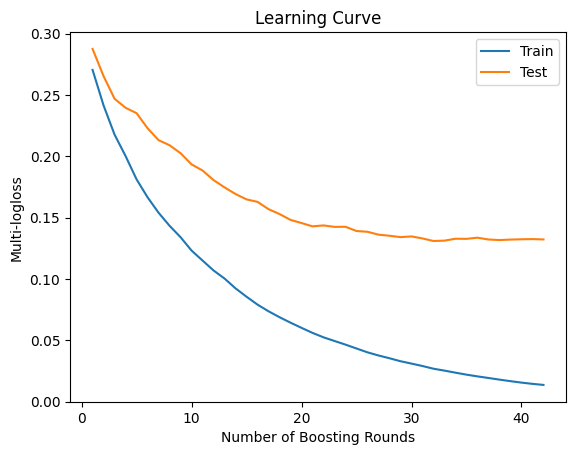

***********************************************************************************
Model                       =  lightGBM
Feature Selection Criteria  =  pca
Train Accuracy              =  0.9983221476510067
Test Accuracy               =  0.9463087248322147


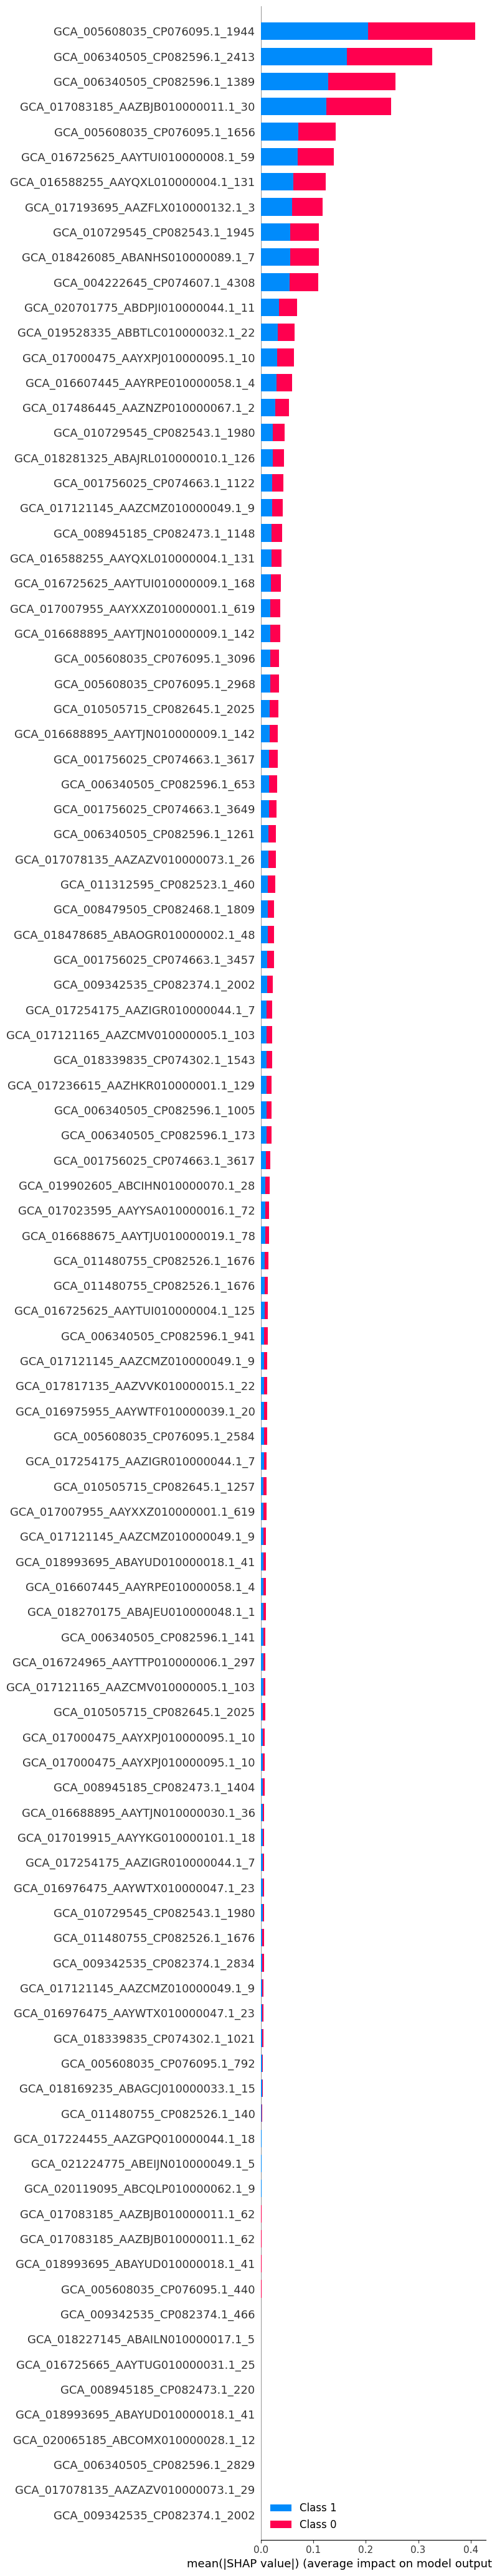

Model Selection  Train_Accuracy  Test_Accuracy
0      DecisionTreeGini       pca        0.897645       0.926174
1   DecisionTreeEntropy       pca        0.919429       0.906040
2          RandomForest       pca        0.926154       0.912752
3                   SVM       pca        0.916096       0.912752
4               XGBoost       pca        0.934572       0.946309
5              lightGBM       pca        1.000000       0.932886
6                   MLP       pca        0.934538       0.946309
7                   cnn       pca        0.850625       0.946309
8      DecisionTreeGini       mca        0.890945       0.912752
9   DecisionTreeEntropy       mca        0.894269       0.899329
10         RandomForest       mca        0.927829       0.919463
11                  SVM       mca        0.916096       0.912752
12              XGBoost       mca        0.926180       0.926174
13             lightGBM       mca        1.000000       0.906040
14                  MLP       mca        0.946280       0.959732
15                  cnn       mca        0.907695       0.959732

In [52]:
### Salmonella -> Add a gene to the dataset present in all "Bovine" samples, and absent in the rest.
### Perform a One vs All binary pipeline trying to predict the Bovine Samples

# Run 06/03
import warnings
warnings.filterwarnings('ignore')

# path for the dataset
dataset_path = "/projects/leaph/sandeep/ncbi_dataset/dataset_PresenceAbsence.csv"
feature_names_path = "/projects/leaph/sandeep/ncbi_dataset/feature_names_PresenceAbsence.csv"
feature_names = pd.read_csv(feature_names_path, header=None)[0].tolist()
feature_names.append("dummy_gene")

selections = ['pca', 'mca']
models = ['DecisionTreeGini','DecisionTreeEntropy','RandomForest','SVM','XGBoost','lightGBM','MLP','cnn'] # Default ML Models

# Target encoding is a dictionary you need to provide to the pipeline
target_encoding = {'Bovine': 1, 'Environmental': 0, 'Poultry': 0, 'Swine': 0, 'Wild bird': 0}

results = pipeline(dataset_path, target_encoding, selections=selections, models=models, nucleotides_data=True)
results